In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
# import keras_tuner as kt
import seaborn as sns
from datetime import datetime

In [3]:
os.chdir('drive/My Drive/Nbeats')

In [5]:
with open('model_para_arr.pickle','rb') as f:
  model_para_arr = pickle.load(f)

In [6]:
with open('ipfiles.pickle','rb') as f:
  ipfiles = pickle.load(f)

In [7]:
def oobsplit(pddata:pd.DataFrame):
  ''' splitting 75% for training and 25% for  testing'''
  
  splitSize = int(len(pddata)*0.75)
  data = pddata.iloc[:splitSize,:]
  oofdata = pddata.iloc[splitSize:,:]

  return data,oofdata


In [8]:
def make_window(data:pd.DataFrame):
  ''' creating columns with previous timestamp's values'''
  
  t2 = data.copy()
  t2 = t2[['value']]
  # Add windowed columns
  for i in range(50): # Shifting values for each step to create 50 subsequent cols.
    t2[f"value-{i+1}"] = t2["value"].shift(periods=i+1)
  return t2.dropna()

In [9]:
def WindowHorizon(data,WINDOW_SIZE,HORIZON,oob = False):
  '''first breaking the training data into Train and
  validation data using split_size. Then using the window+horizon number of 
  columns from the 50 columns we have generated in make_window func'''

  if oob == False:# when using bag/train data
    split_size = int(len(data)*0.8)
    
    data = data.iloc[:,:WINDOW_SIZE+HORIZON]
  
    xtr = data.iloc[:split_size,-WINDOW_SIZE:]
    ytr = data.iloc[:split_size,:HORIZON]
    xts = data.iloc[split_size:,-WINDOW_SIZE:]
    yts = data.iloc[split_size:,:HORIZON]

    return xtr,ytr,xts,yts
  elif oob == True:# when using oob/test data we dont need to split it
    
    data = data.iloc[:,:WINDOW_SIZE+HORIZON]
  
    xtr = data.iloc[:,-WINDOW_SIZE:]
    ytr = data.iloc[:,:HORIZON]
    
    return xtr,ytr
  

In [11]:
def tensorize_data(xtr:pd.DataFrame,ytr:pd.DataFrame,xts:pd.DataFrame,yts:pd.DataFrame,BATCH_SIZE):
    '''generating the tensor out of data to feed to neural network'''

  train_features_dataset = tf.data.Dataset.from_tensor_slices(xtr)
  train_labels_dataset = tf.data.Dataset.from_tensor_slices(ytr)

  test_features_dataset = tf.data.Dataset.from_tensor_slices(xts)
  test_labels_dataset = tf.data.Dataset.from_tensor_slices(yts)

  train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
  test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

  train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return train_dataset, test_dataset

In [12]:
def prep_data(data,WINDOW_SIZE,HORIZON,BATCH_SIZE,oob =False):
  ''' calling all the 3 functions to prepare the data at
  one place'''
  if oob == False:# while working with 75% data we need train and validation set
    data = make_window(data)
    xtr,ytr,xts,yts = WindowHorizon(data,WINDOW_SIZE,HORIZON)
    train_dataset, test_dataset = tensorize_data(xtr,ytr,xts,yts,BATCH_SIZE)

    return train_dataset, test_dataset

  elif oob == True:# while working with 25% data we do not need validation set
    data = make_window(data)
    xtr,ytr = WindowHorizon(data,WINDOW_SIZE,HORIZON,oob)
    oob_features_dataset = tf.data.Dataset.from_tensor_slices(xtr)
    oob_labels_dataset = tf.data.Dataset.from_tensor_slices(ytr)
    oob_dataset = tf.data.Dataset.zip((oob_features_dataset, oob_labels_dataset))
    oob_dataset = oob_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return oob_dataset


In [13]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.dense_layers = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.dense_layers: 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast




#Nbeats architecture

def ModelTrain(train_dataset,test_dataset,**kwargs):
  ''' Training the model with best parameters obtained in
  the hypertune phase'''
  
  WINDOW_SIZE= kwargs['WINDOW_SIZE']
  HORIZON = kwargs['HORIZON']

  N_EPOCHS = 1000
  N_NEURONS = kwargs['N_NEURONS']
  N_LAYERS = 4
  N_STACKS = kwargs['N_STACKS']
  BATCH_SIZE = 128 

  INPUT_SIZE = WINDOW_SIZE 
  THETA_SIZE = INPUT_SIZE + HORIZON
  INPUT_SIZE, THETA_SIZE


  tf.random.set_seed(5)

  nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name="InitialBlock")

  stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

  backcast, forecast = nbeats_block_layer(stack_input)
  residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

  for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals) # pass it in residuals (the backcast)

    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

  model = tf.keras.Model(inputs=stack_input, 
                          outputs=forecast, 
                          name="model_N-BEATS")

  model.compile(loss="mape",
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  )
  model.fit(train_dataset,
              epochs=N_EPOCHS,
              validation_data=test_dataset,
              verbose=0, 
              # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch takes too much time
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10, verbose=0),
                        #  tf.keras.callbacks.ModelCheckpoint(FILEPATH, monitor='val_loss',verbose=0,save_best_only=True, mode='min') # need to write a get_config method for this
                        ])

  return model


In [14]:
def make_preds(model, input_data):
   return tf.squeeze(model.predict(input_data))

In [15]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate all the req metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred).numpy().mean()
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred).numpy().mean() 
  rmse = tf.sqrt(mse).numpy().mean()
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred).numpy().mean()
  
  return {"MAE": mae,
          "MSE": mse,
          "RMSE": rmse,
          "MAPE": mape,
          }

In [16]:
def plot_preds(pddata,i,ytrue,preds,score):
  size = int(len(pddata)*0.75)
  x1 = pddata.iloc[:size,:]['timestamp']
  y1 = pddata.iloc[:size,:]['value']
  x2 = pddata.iloc[size:,:]['timestamp']
  y2 = ytrue.value
  x3 = pddata.iloc[size:,:]['timestamp']
  y3 = preds


  plt.figure(figsize=(25, 8))
  plt.title(f'Dataset{i}')
  plt.plot(x1, y1, label = "train")
  plt.plot(x2, y2, label = "ytrue",linestyle='dashed')
  plt.plot(x3, y3, label = "pred",linestyle='dashed')


  plt.legend()
  plt.show()
  plt.close()
  print(score)

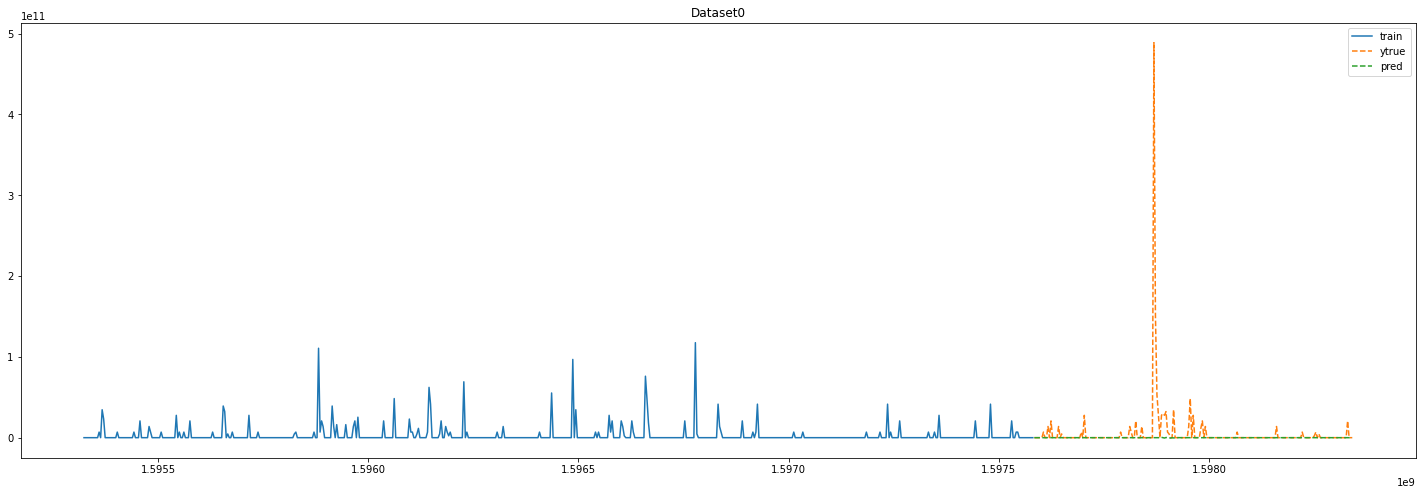

{'MAE': 5914496500.0, 'MSE': 1.3232859e+21, 'RMSE': 36376998000.0, 'MAPE': 1033931.06}


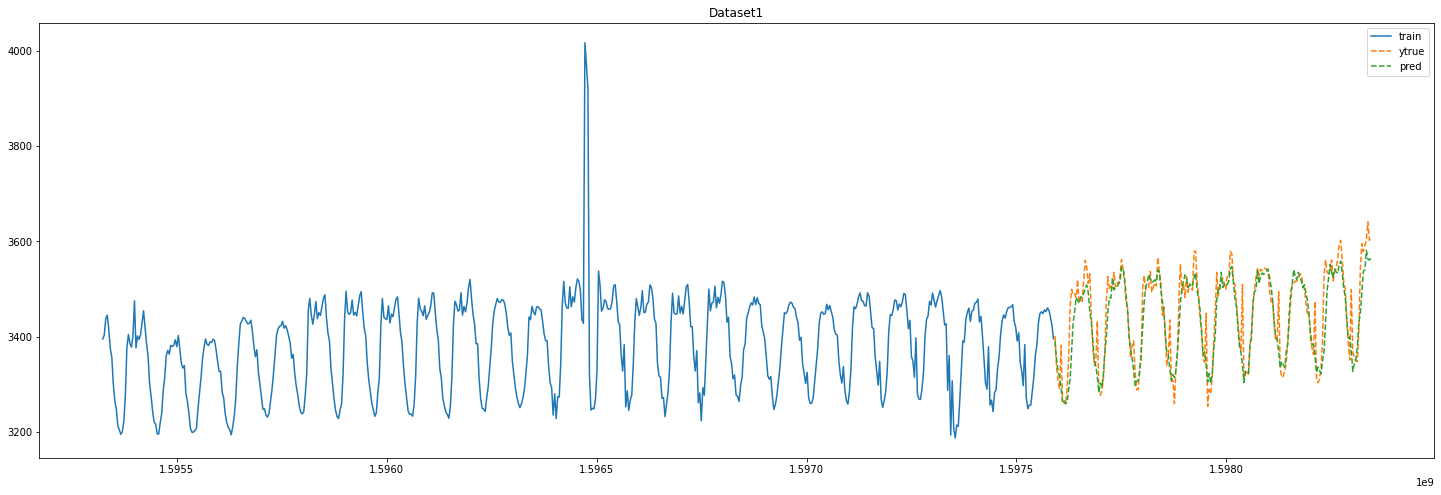

{'MAE': 26.091936, 'MSE': 1559.3593, 'RMSE': 39.488724, 'MAPE': 0.75258905}


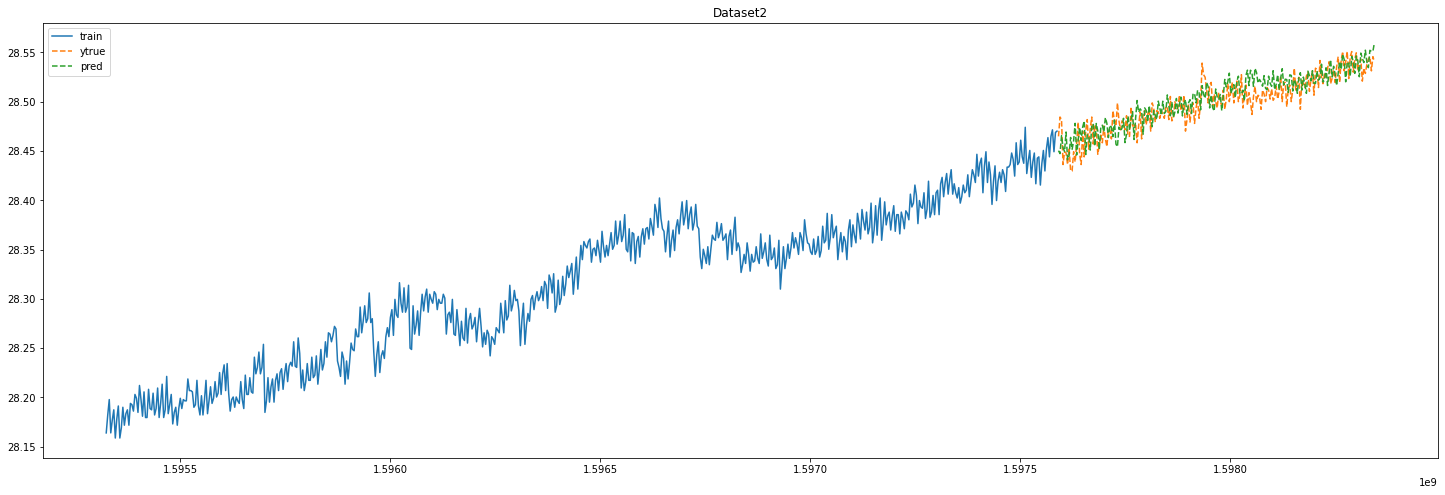

{'MAE': 0.012785185, 'MSE': 0.00024372037, 'RMSE': 0.015611546, 'MAPE': 0.044868648}


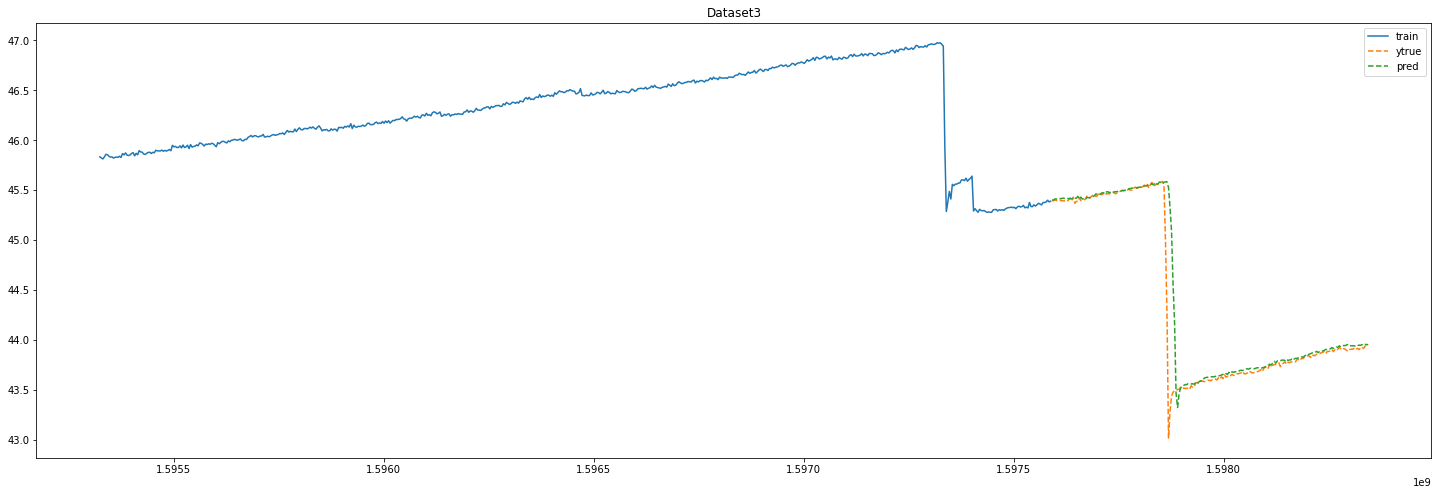

{'MAE': 0.06221516, 'MSE': 0.06076593, 'RMSE': 0.24650747, 'MAPE': 0.14226447}


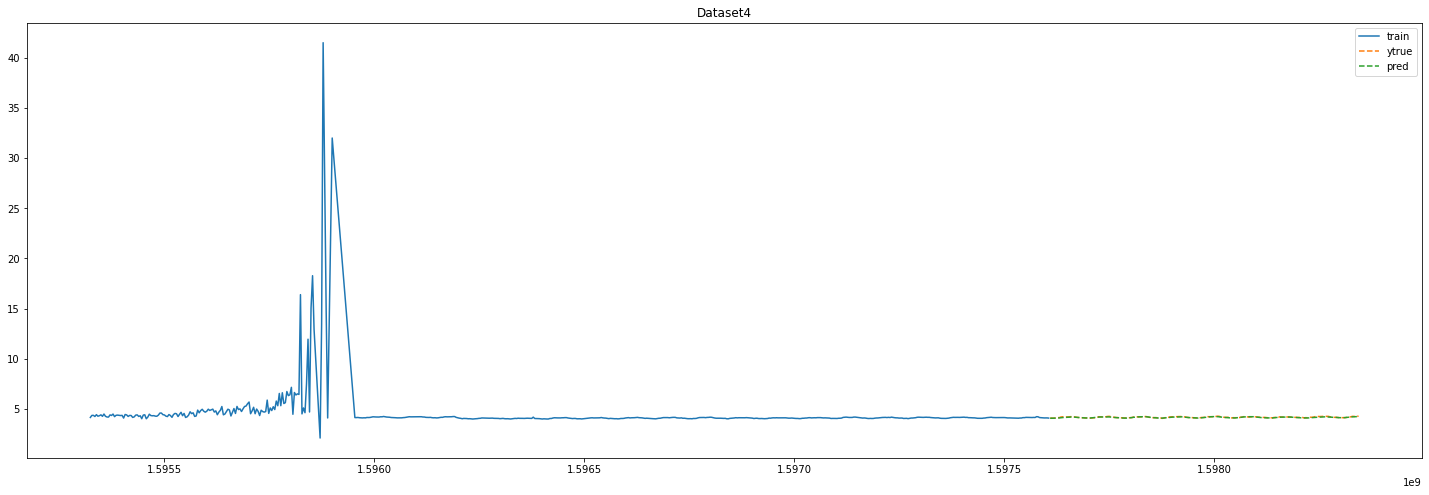

{'MAE': 0.0181412, 'MSE': 0.0005751681, 'RMSE': 0.023982663, 'MAPE': 0.4330317}


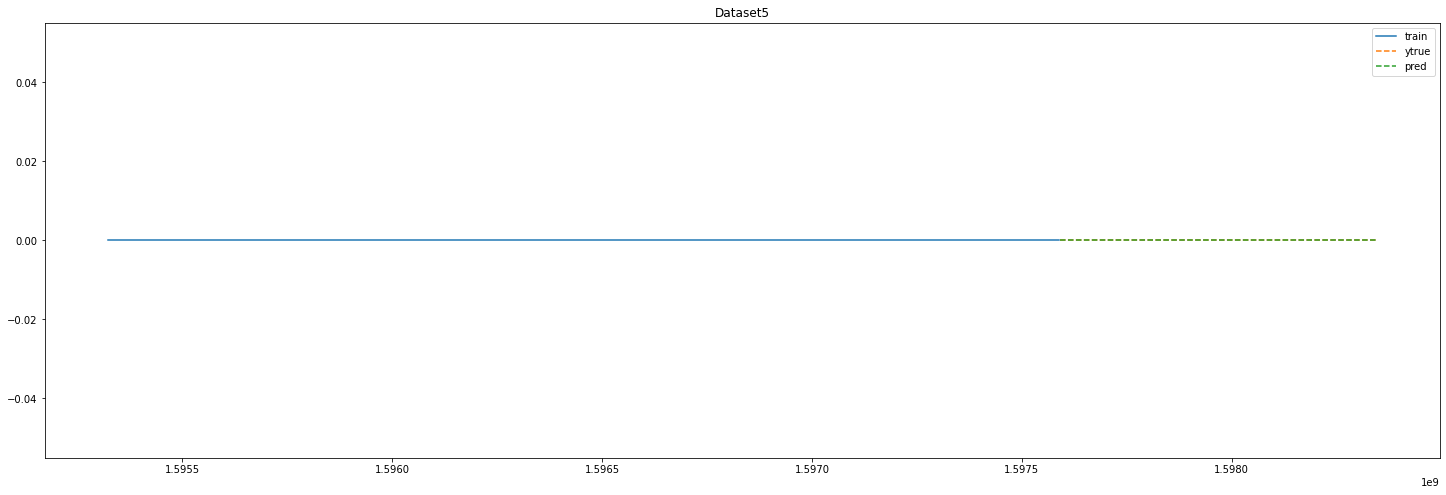

{'MAE': 0.0, 'MSE': 0.0, 'RMSE': 0.0, 'MAPE': 0.0}


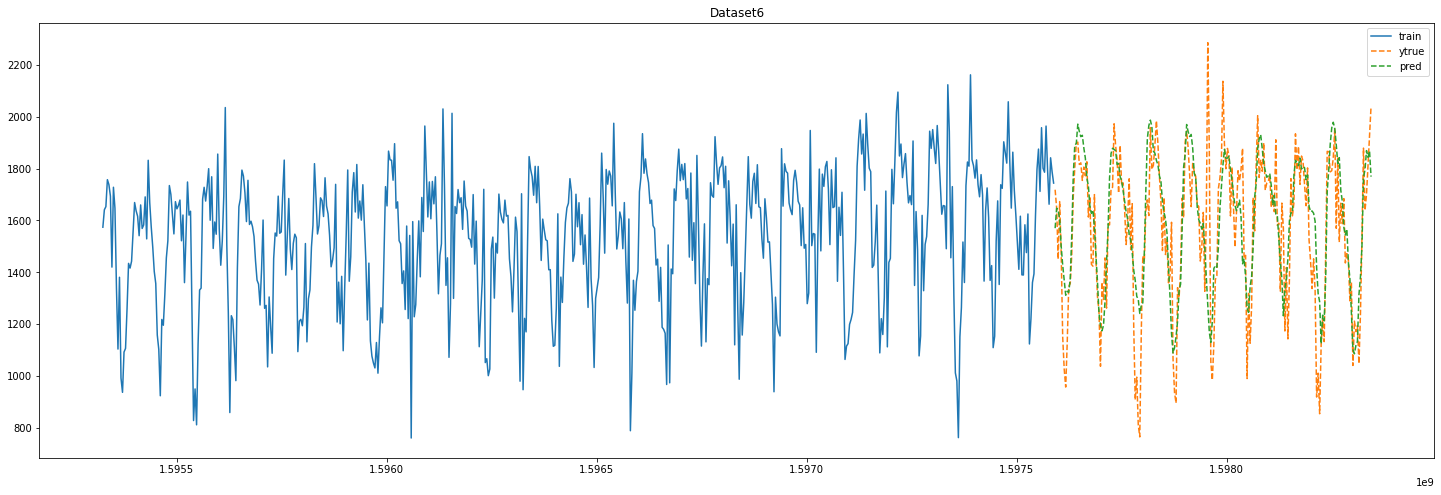

{'MAE': 128.19205, 'MSE': 31421.385, 'RMSE': 177.26079, 'MAPE': 8.931342}


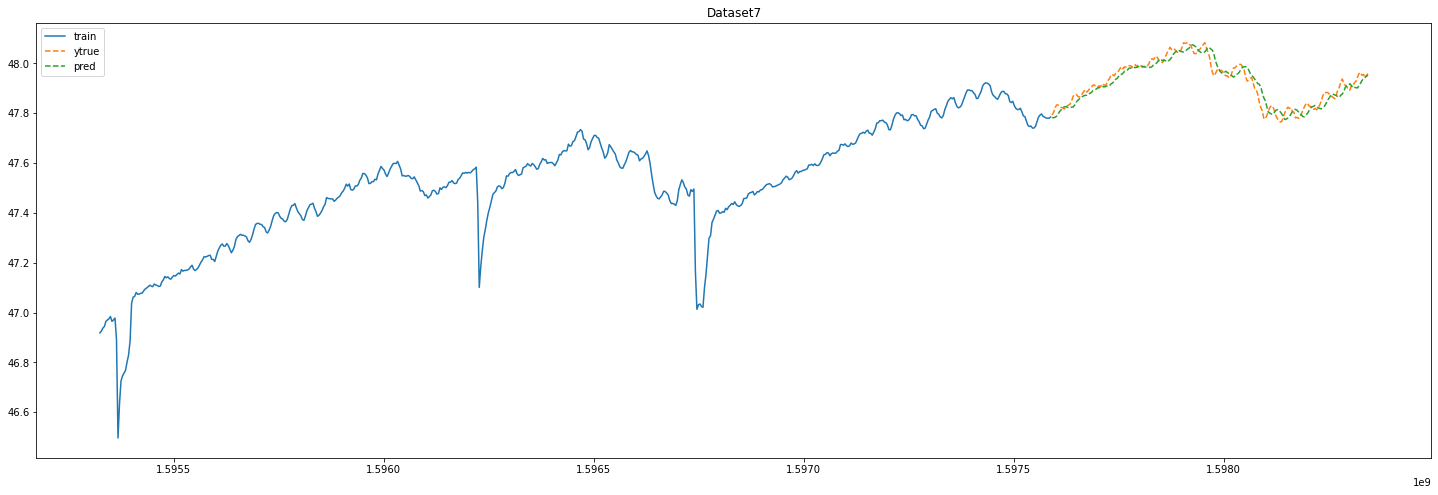

{'MAE': 0.019617425, 'MSE': 0.00065227674, 'RMSE': 0.02553971, 'MAPE': 0.04094308}


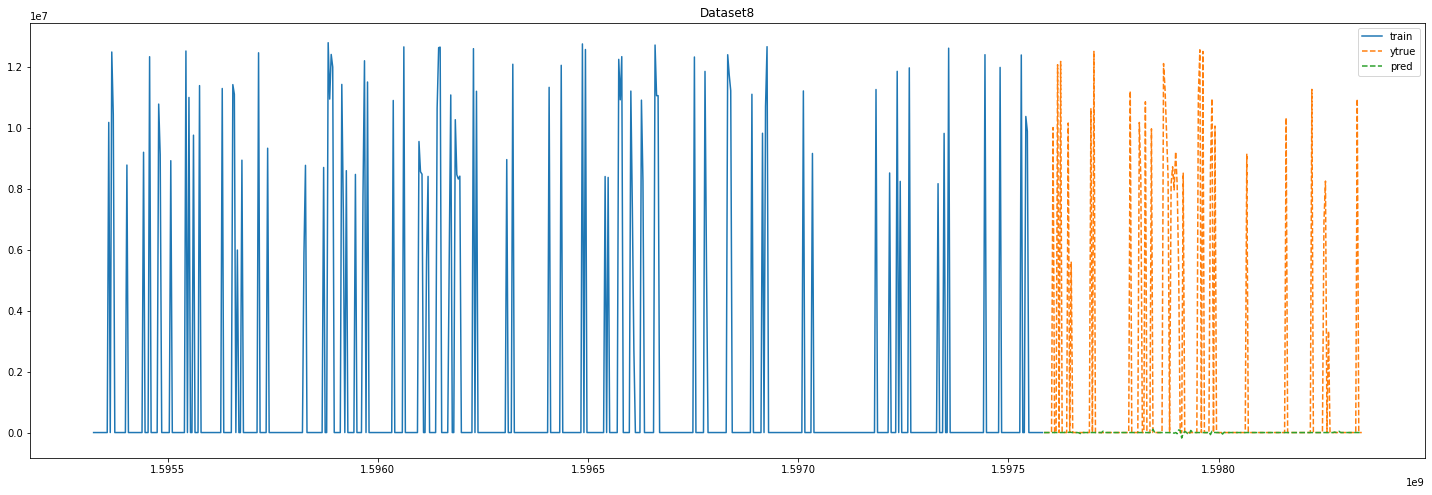

{'MAE': 1646744.4, 'MSE': 16583978000000.0, 'RMSE': 4072343.0, 'MAPE': 104281.47}


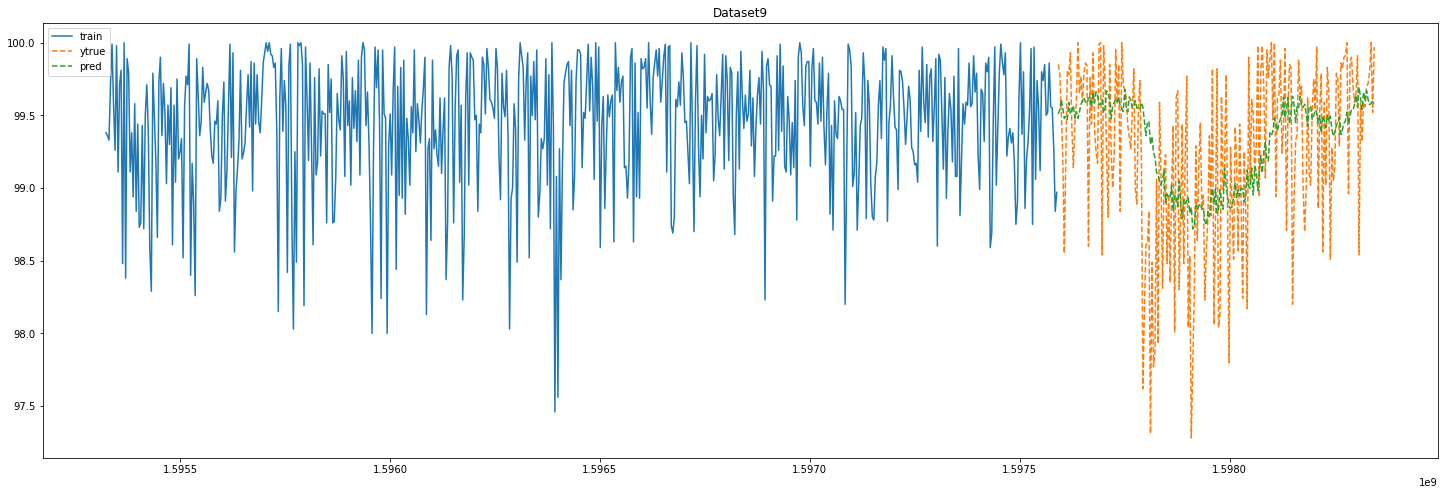

{'MAE': 0.52880436, 'MSE': 0.45376965, 'RMSE': 0.6736243, 'MAPE': 0.5342156}


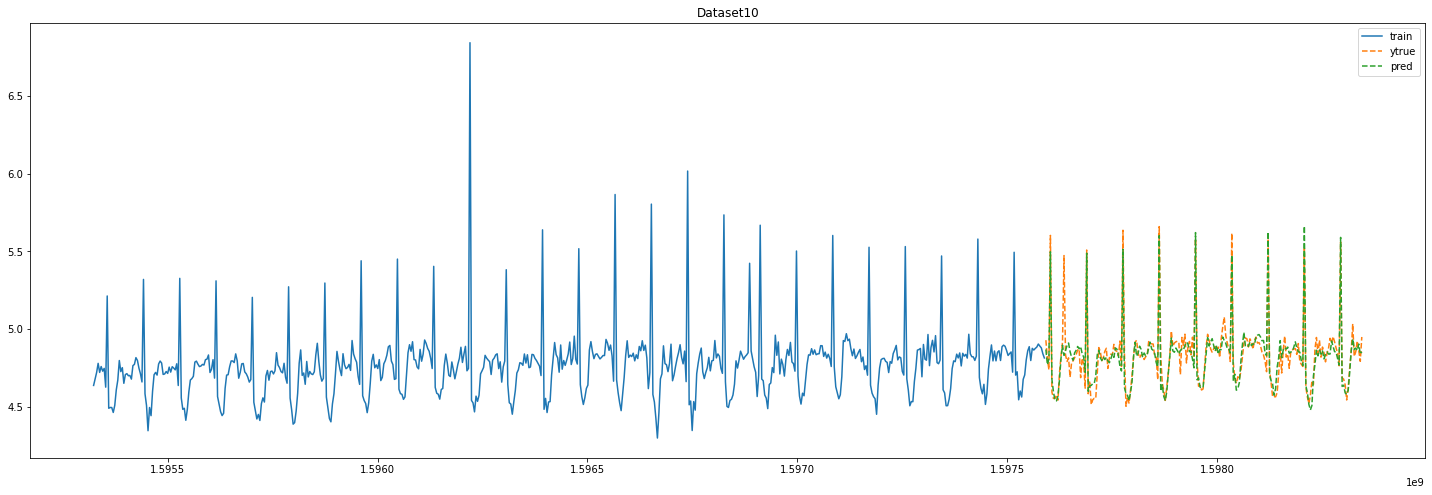

{'MAE': 0.052882638, 'MSE': 0.006175357, 'RMSE': 0.078583434, 'MAPE': 1.0875404}


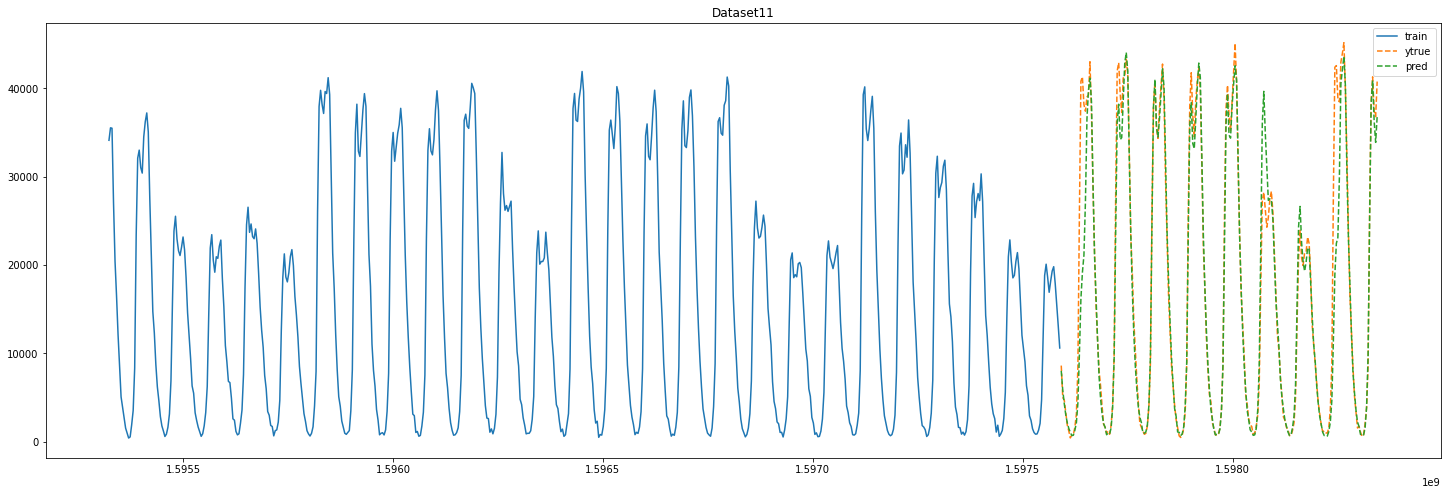

{'MAE': 1315.1666, 'MSE': 9573945.0, 'RMSE': 3094.1792, 'MAPE': 12.354889}


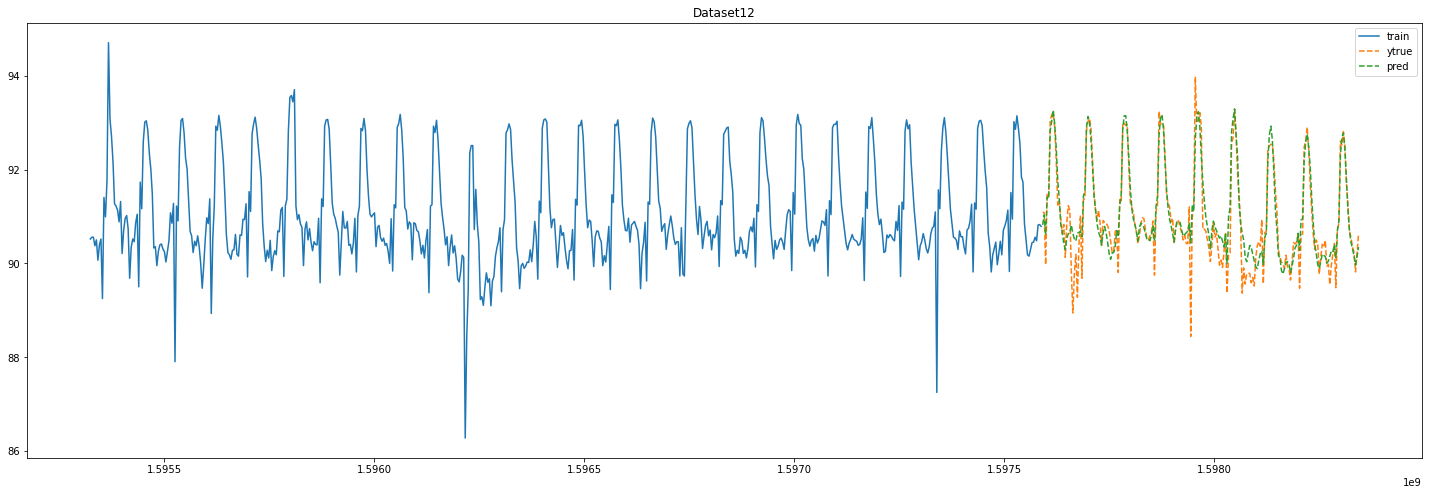

{'MAE': 0.26936805, 'MSE': 0.16111143, 'RMSE': 0.4013869, 'MAPE': 0.29731432}


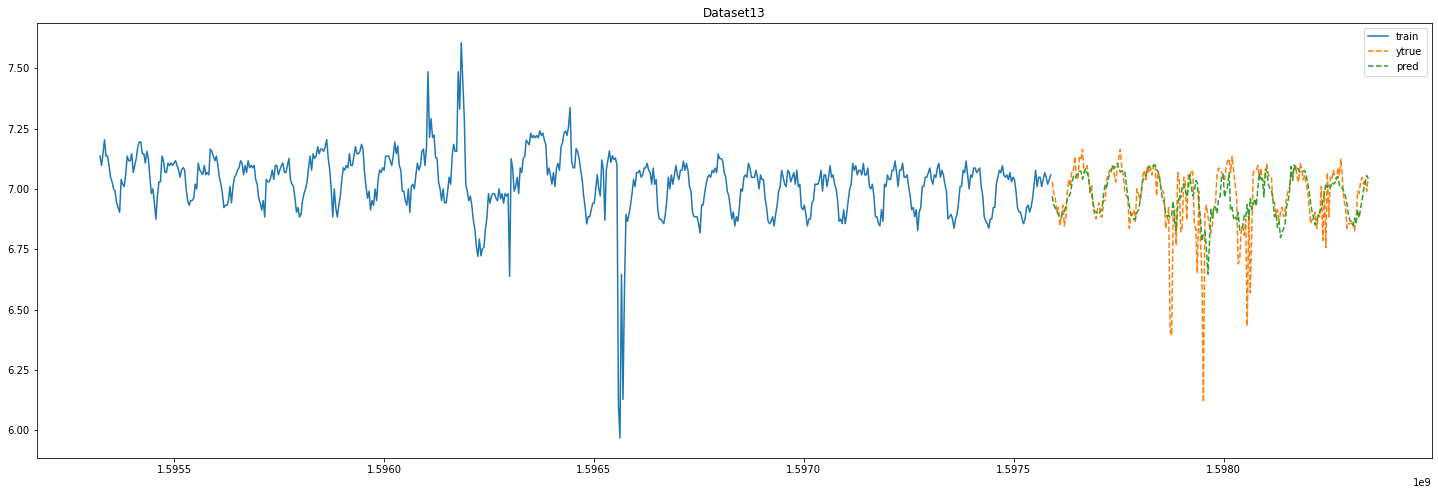

{'MAE': 0.0663214, 'MSE': 0.012076501, 'RMSE': 0.109893136, 'MAPE': 0.97026235}


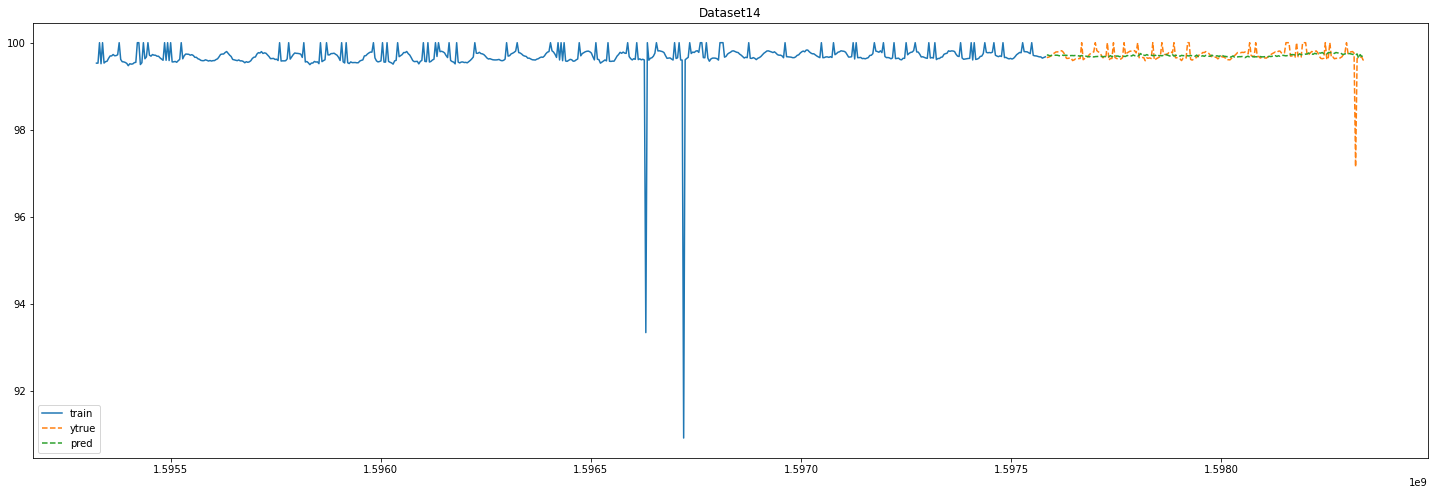

{'MAE': 0.09923757, 'MSE': 0.045968838, 'RMSE': 0.21440344, 'MAPE': 0.09975735}


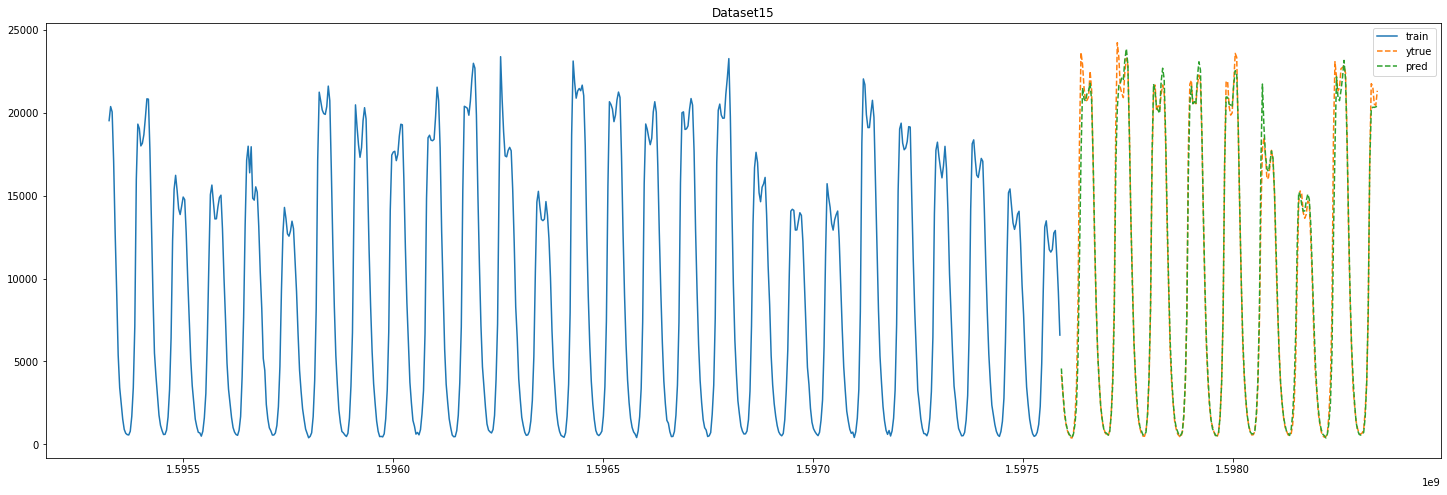

{'MAE': 462.95612, 'MSE': 852192.0, 'RMSE': 923.14246, 'MAPE': 7.5733314}


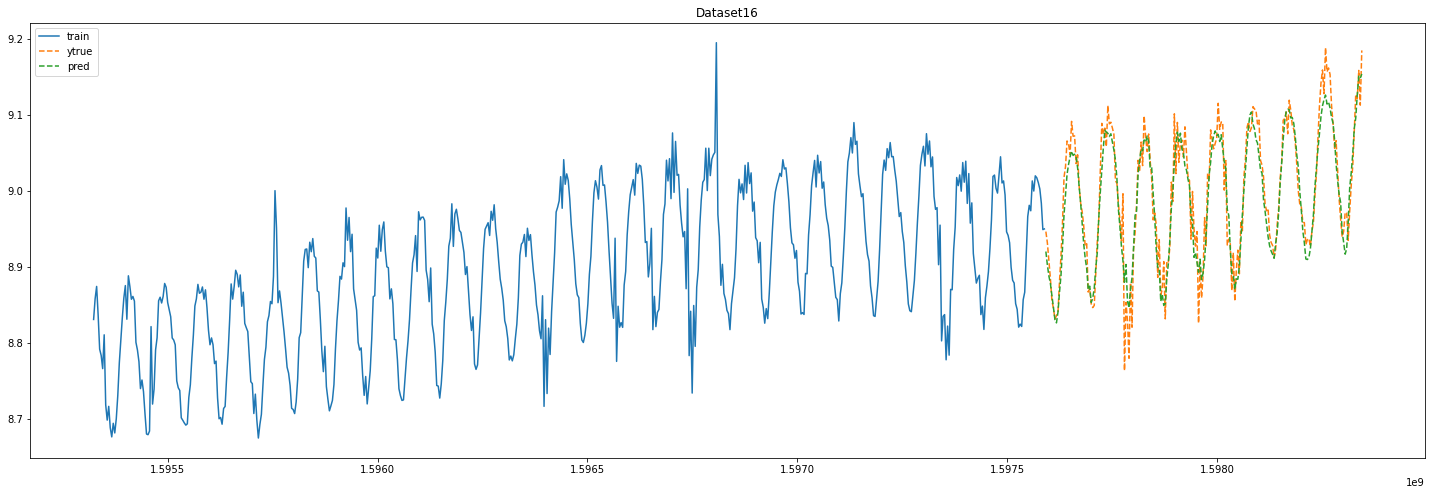

{'MAE': 0.021790631, 'MSE': 0.00081305817, 'RMSE': 0.028514175, 'MAPE': 0.24229774}


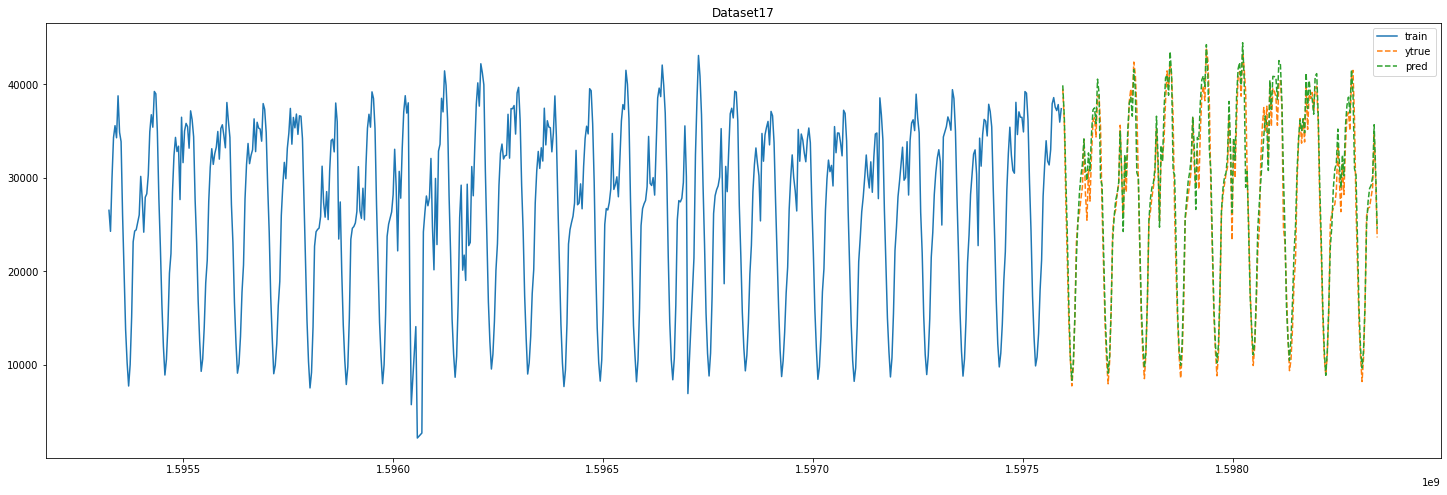

{'MAE': 1277.7686, 'MSE': 3033592.8, 'RMSE': 1741.7212, 'MAPE': 4.9347153}


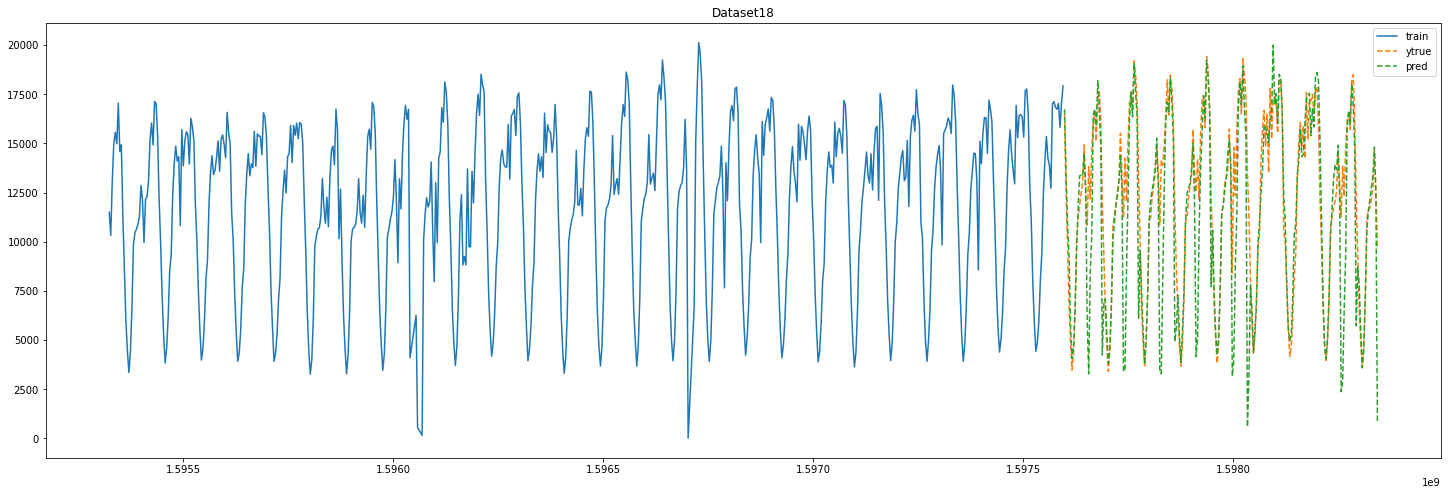

{'MAE': 1231.9115, 'MSE': 5719579.0, 'RMSE': 2391.564, 'MAPE': 10.323231}


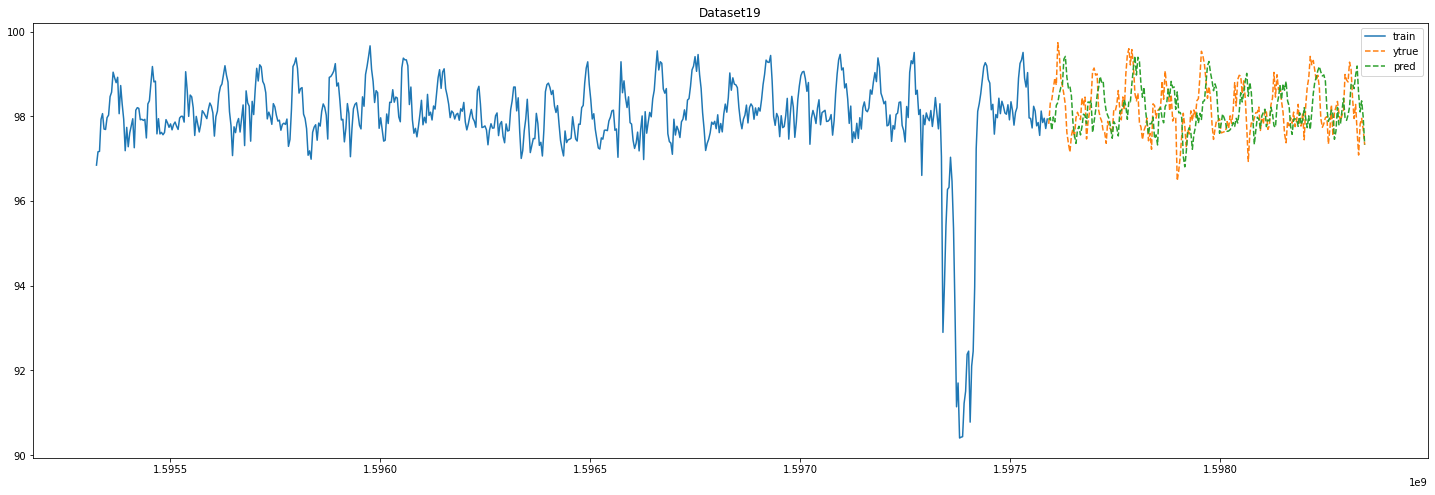

{'MAE': 0.45567125, 'MSE': 0.3402669, 'RMSE': 0.583324, 'MAPE': 0.46407485}


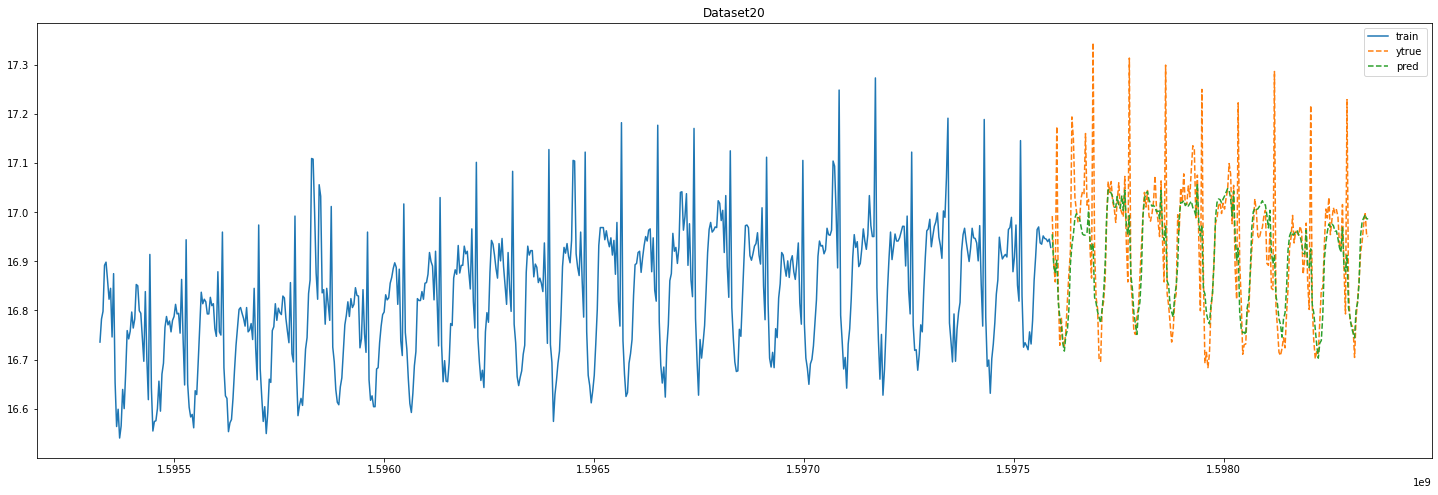

{'MAE': 0.048802644, 'MSE': 0.0073182457, 'RMSE': 0.08554675, 'MAPE': 0.28673518}


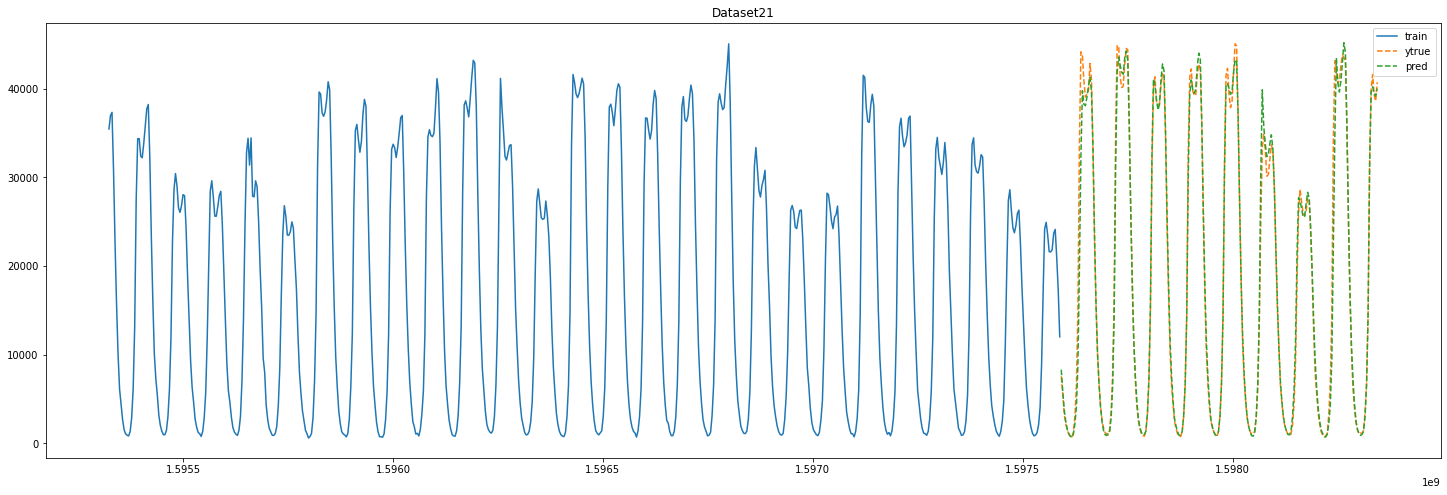

{'MAE': 816.29443, 'MSE': 2772673.2, 'RMSE': 1665.1345, 'MAPE': 7.562828}


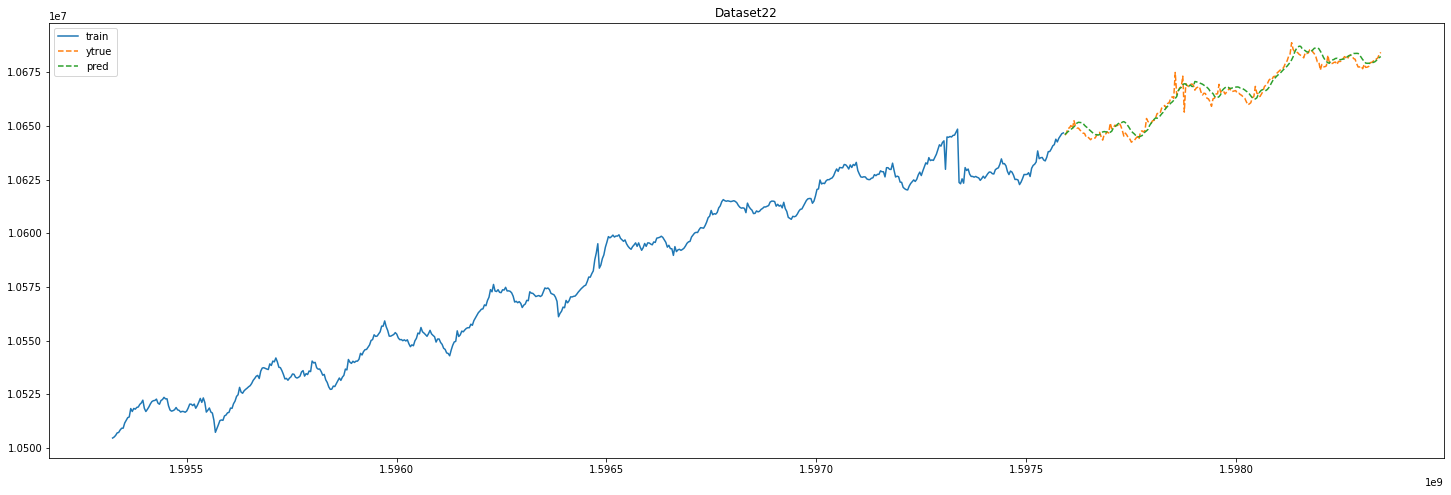

{'MAE': 2144.274, 'MSE': 8233627.0, 'RMSE': 2869.4297, 'MAPE': 0.020106036}


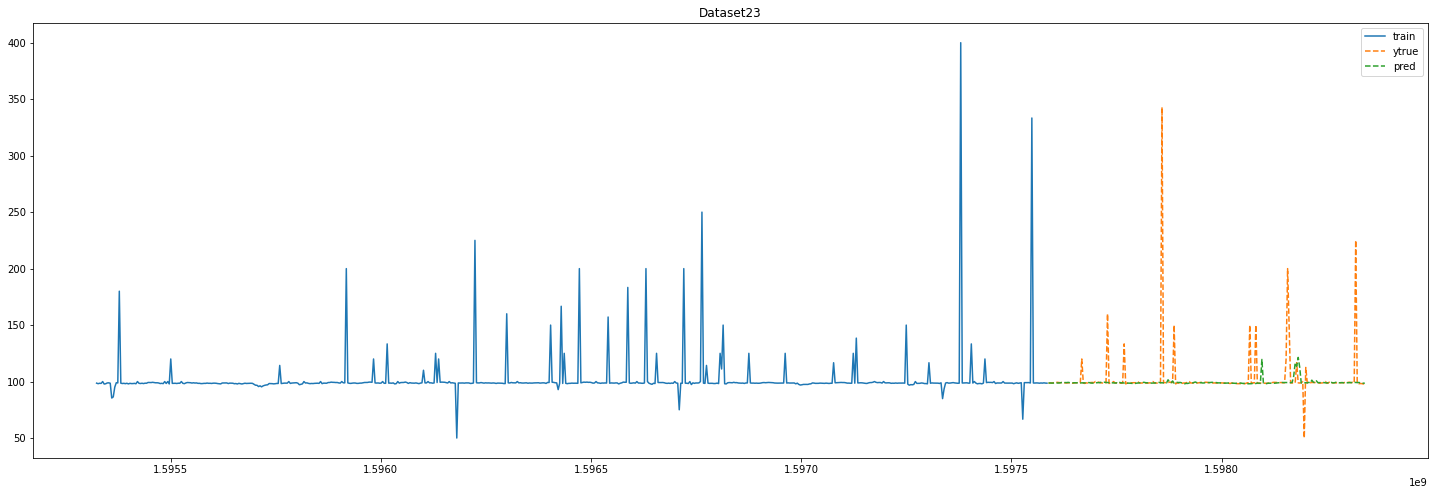

{'MAE': 4.9486933, 'MSE': 504.74783, 'RMSE': 22.466593, 'MAPE': 3.2761278}


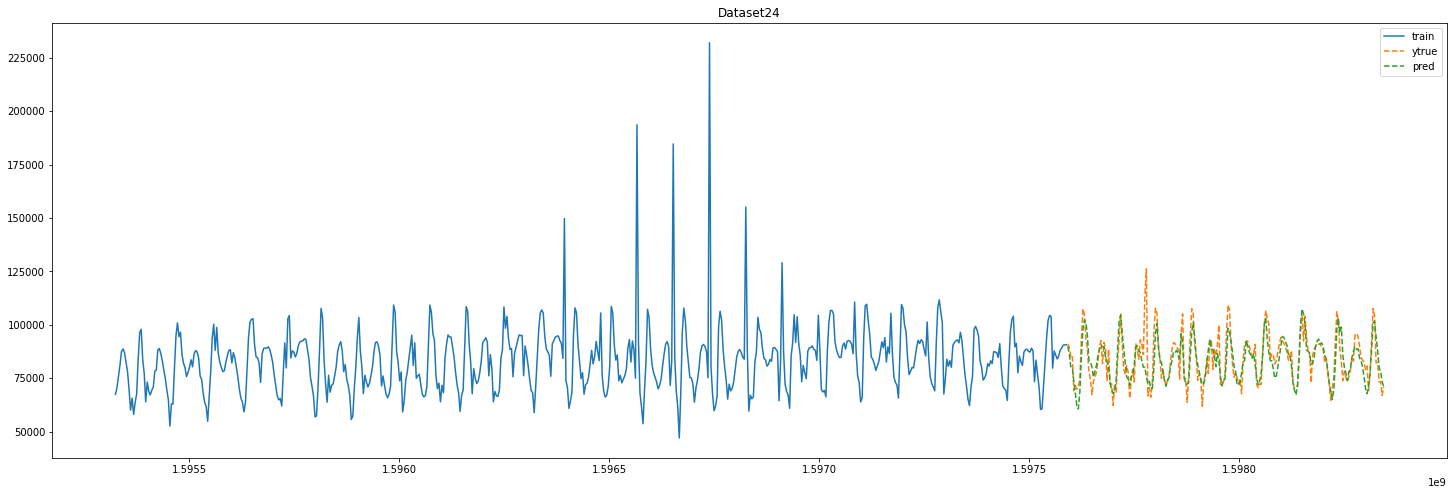

{'MAE': 4711.5, 'MSE': 46784708.0, 'RMSE': 6839.9346, 'MAPE': 5.534847}


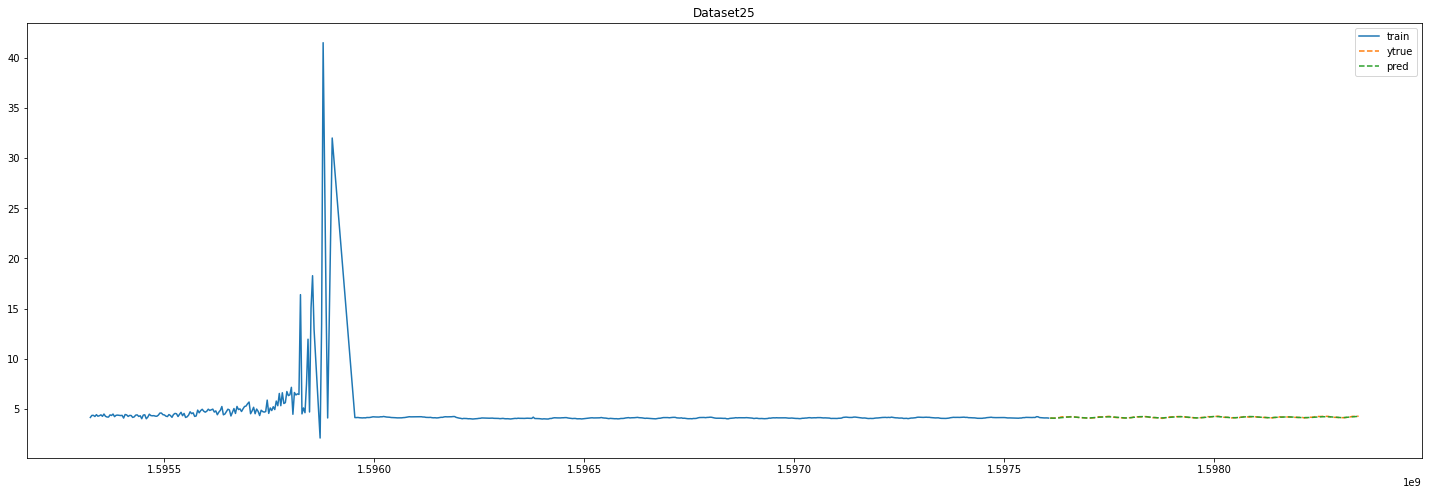

{'MAE': 0.016600993, 'MSE': 0.0004850388, 'RMSE': 0.022023596, 'MAPE': 0.39608744}


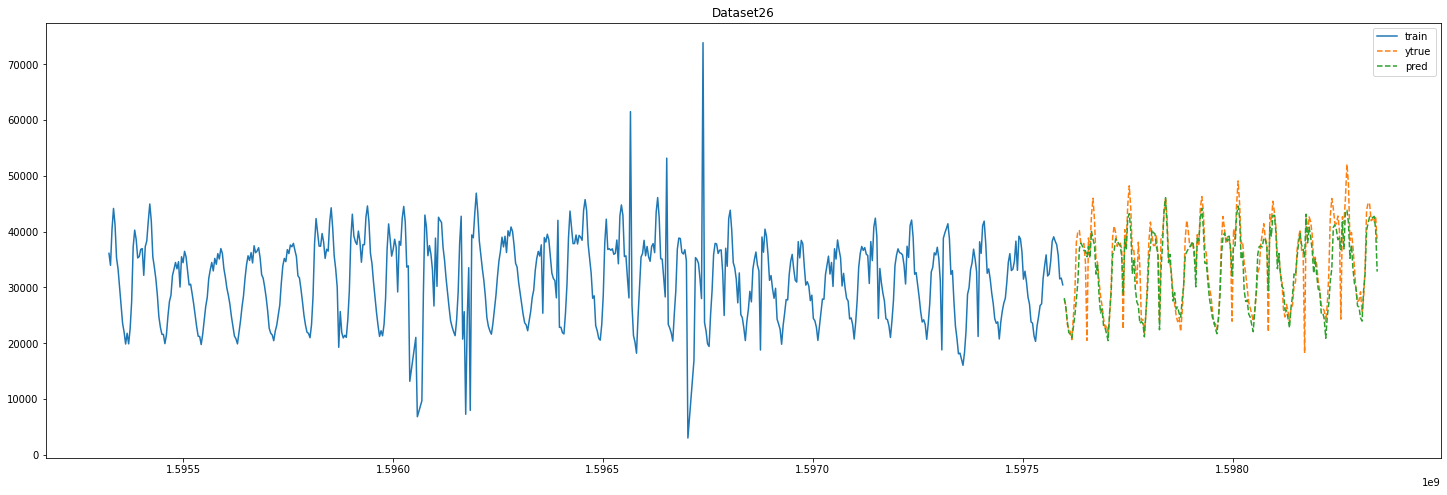

{'MAE': 2174.3635, 'MSE': 11404449.0, 'RMSE': 3377.0474, 'MAPE': 6.722073}


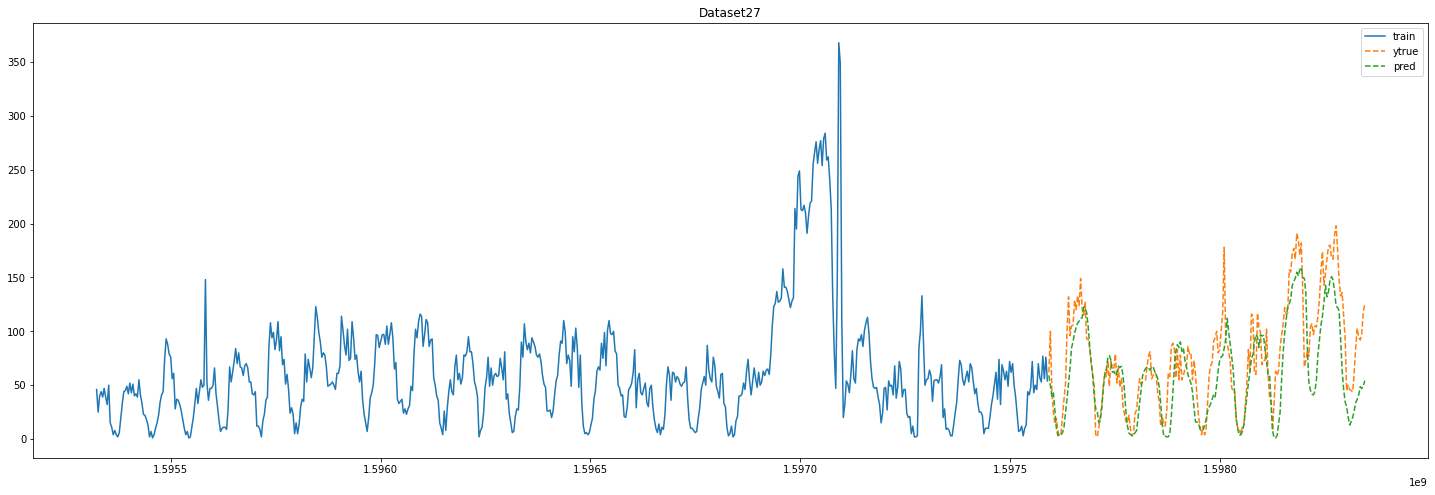

{'MAE': 22.142536, 'MSE': 841.611, 'RMSE': 29.010532, 'MAPE': 41.985863}


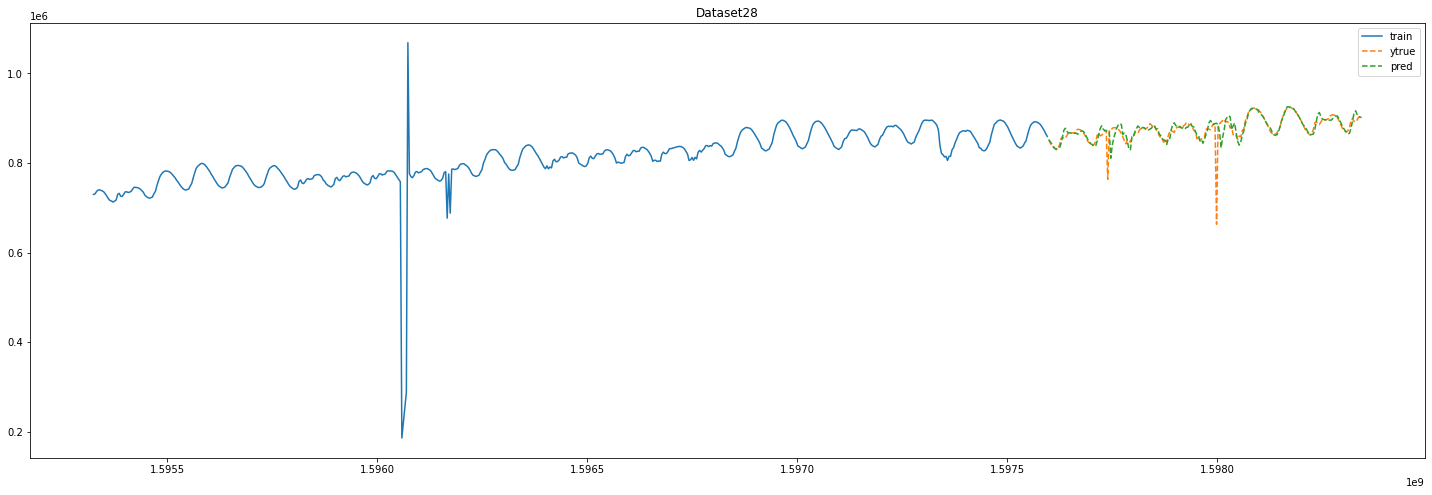

{'MAE': 7860.591, 'MSE': 469953200.0, 'RMSE': 21678.404, 'MAPE': 0.94649374}


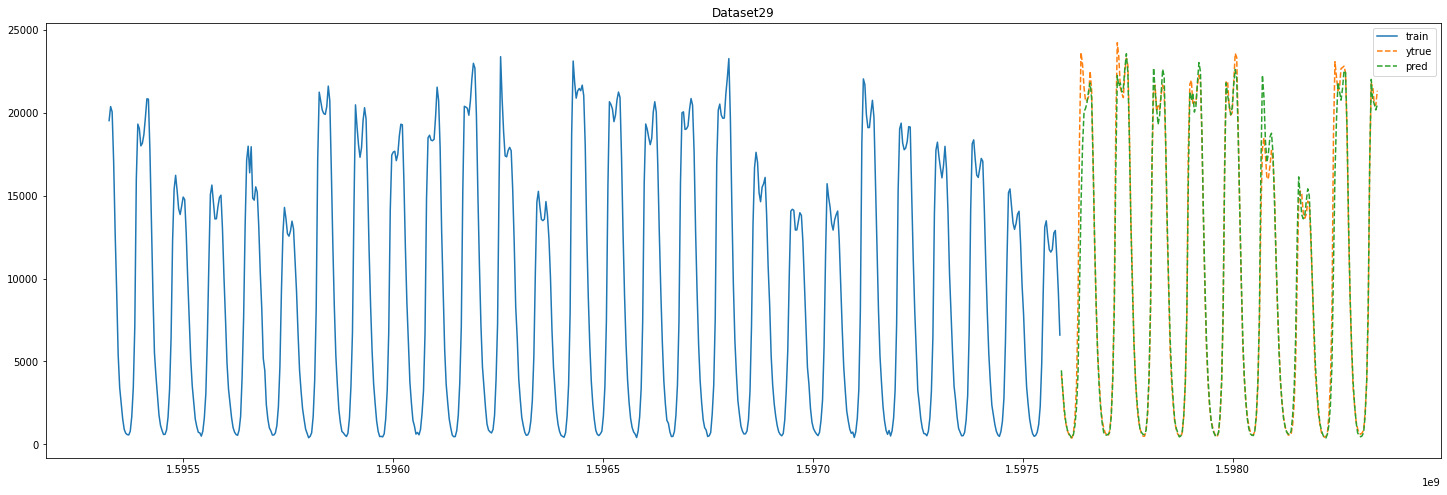

{'MAE': 502.36346, 'MSE': 1209900.1, 'RMSE': 1099.9546, 'MAPE': 7.496311}


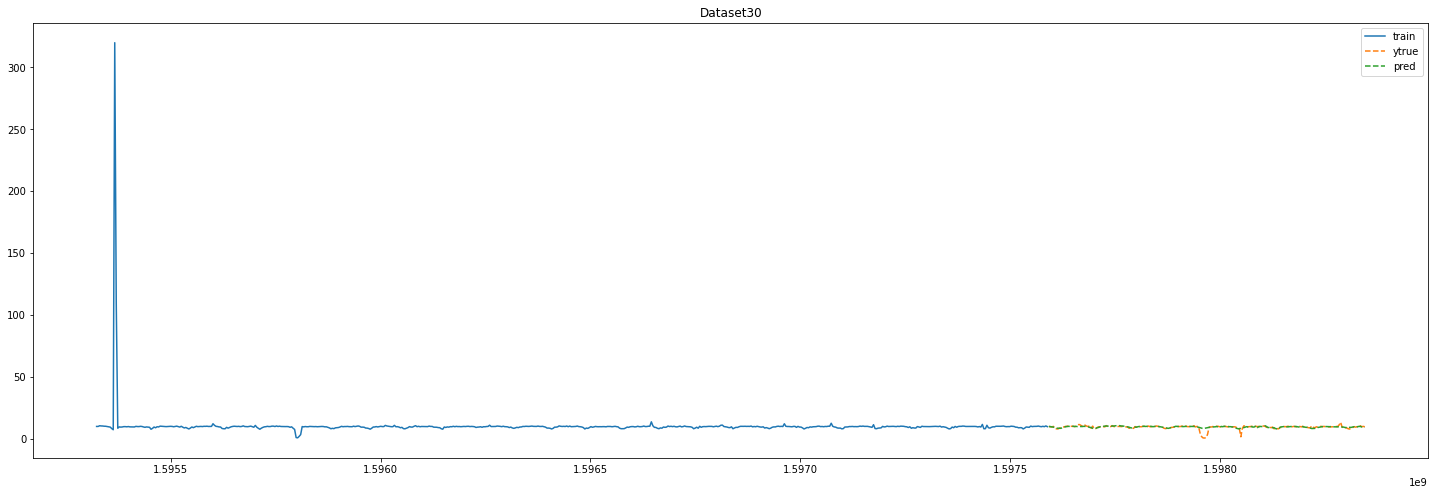

{'MAE': 0.58176285, 'MSE': 1.5141613, 'RMSE': 1.2305126, 'MAPE': 18.761368}


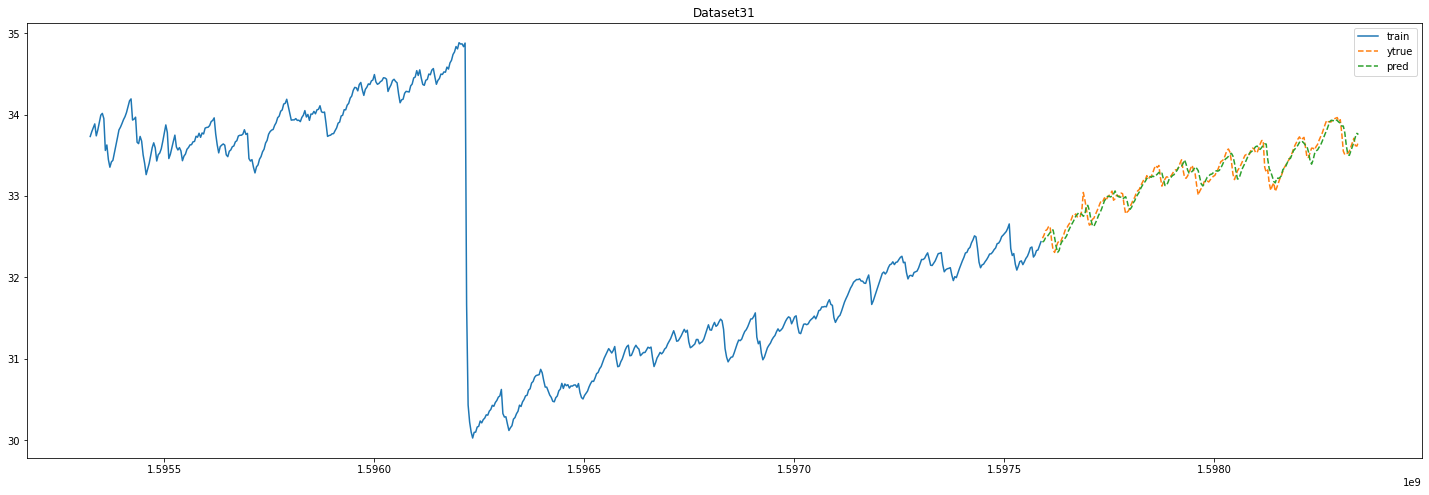

{'MAE': 0.06358927, 'MSE': 0.007284991, 'RMSE': 0.08535216, 'MAPE': 0.19162516}


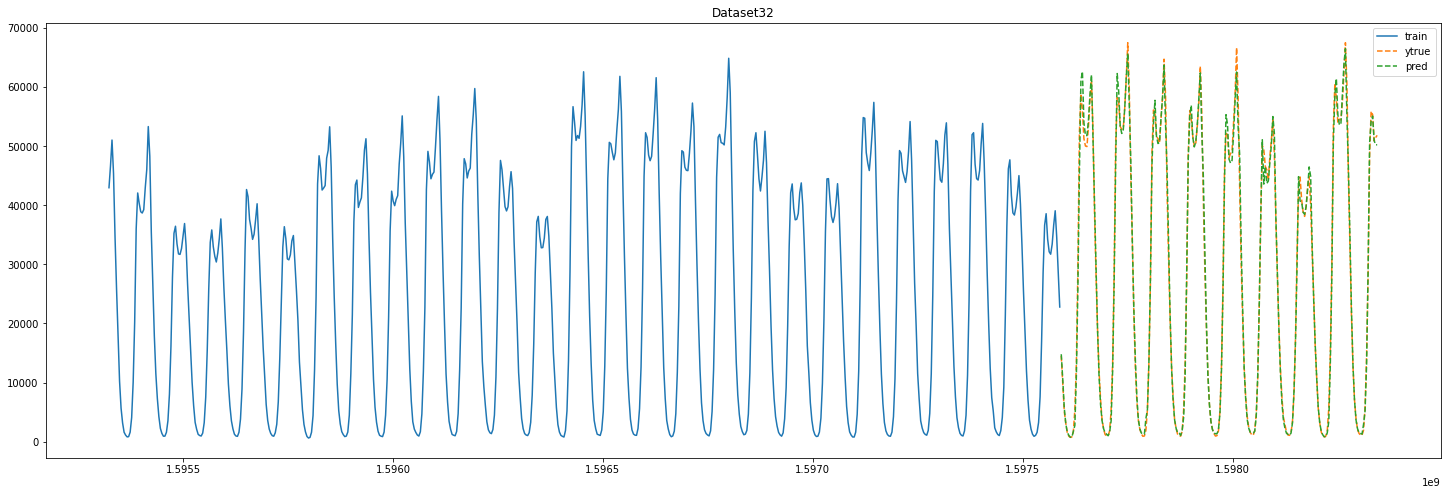

{'MAE': 985.15027, 'MSE': 2416712.5, 'RMSE': 1554.5779, 'MAPE': 6.5844774}


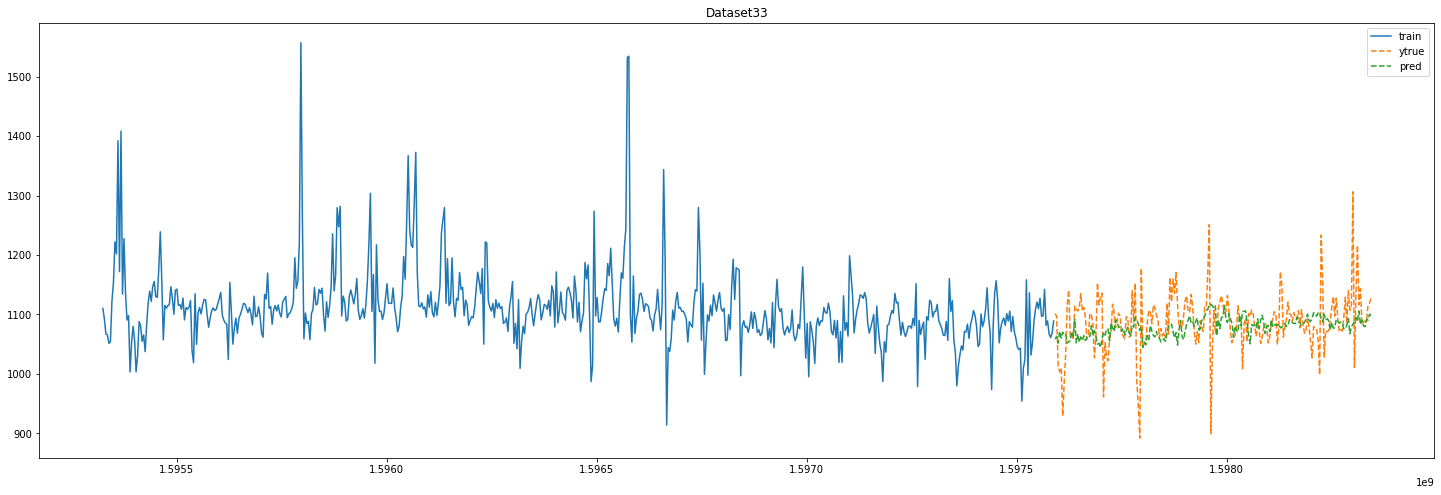

{'MAE': 33.817894, 'MSE': 2507.7708, 'RMSE': 50.077644, 'MAPE': 3.1244297}


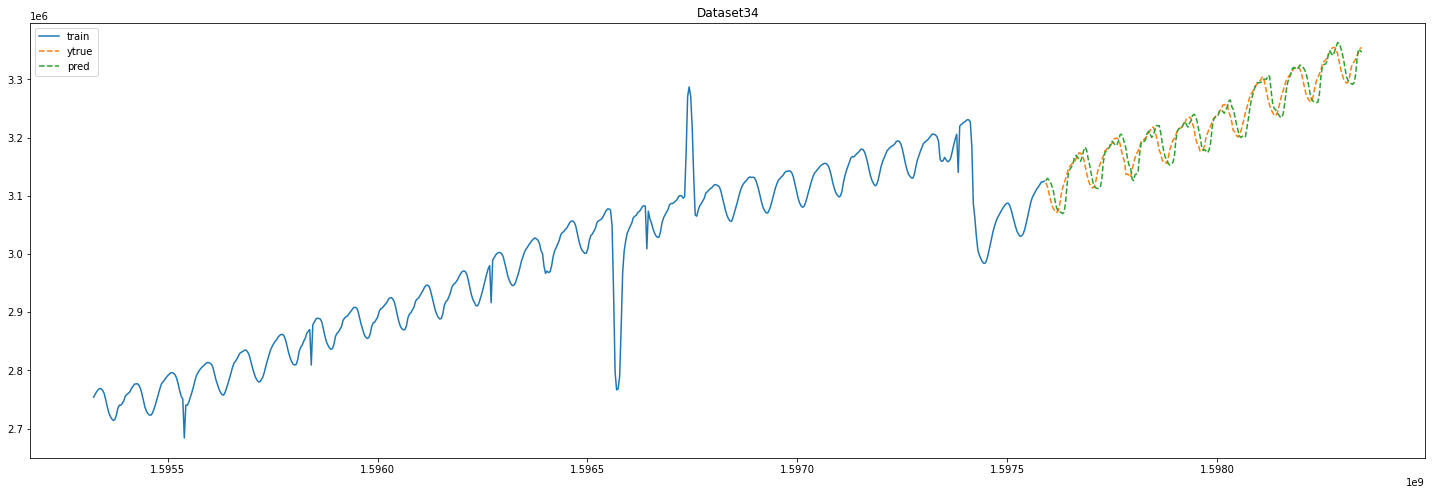

{'MAE': 9919.028, 'MSE': 209819980.0, 'RMSE': 14485.164, 'MAPE': 0.3086513}


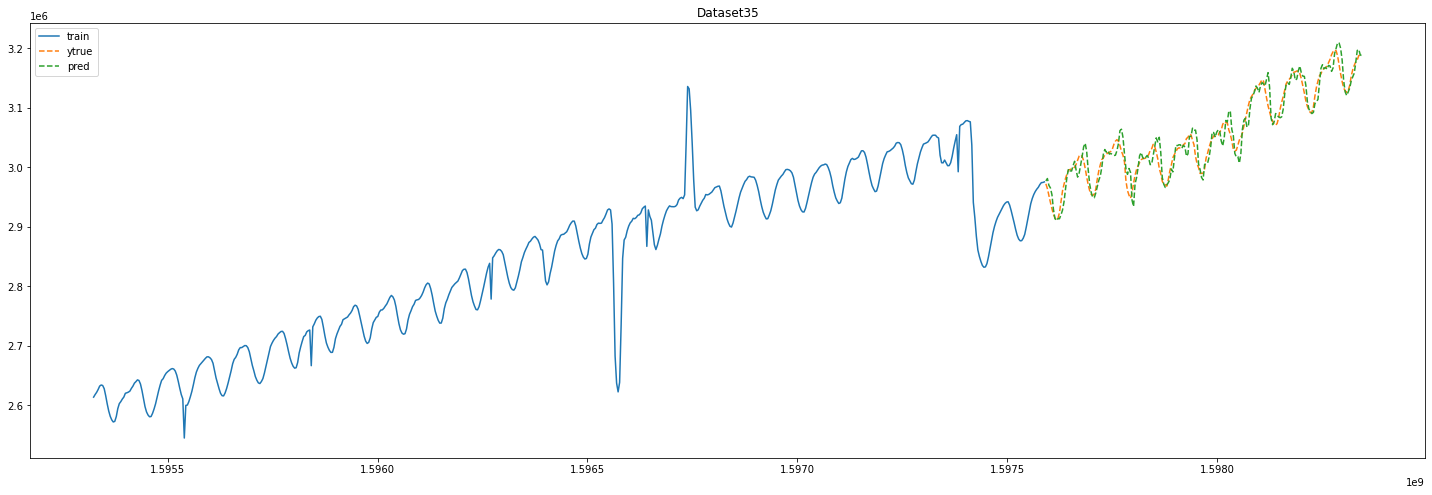

{'MAE': 7971.91, 'MSE': 145313760.0, 'RMSE': 12054.615, 'MAPE': 0.26127028}


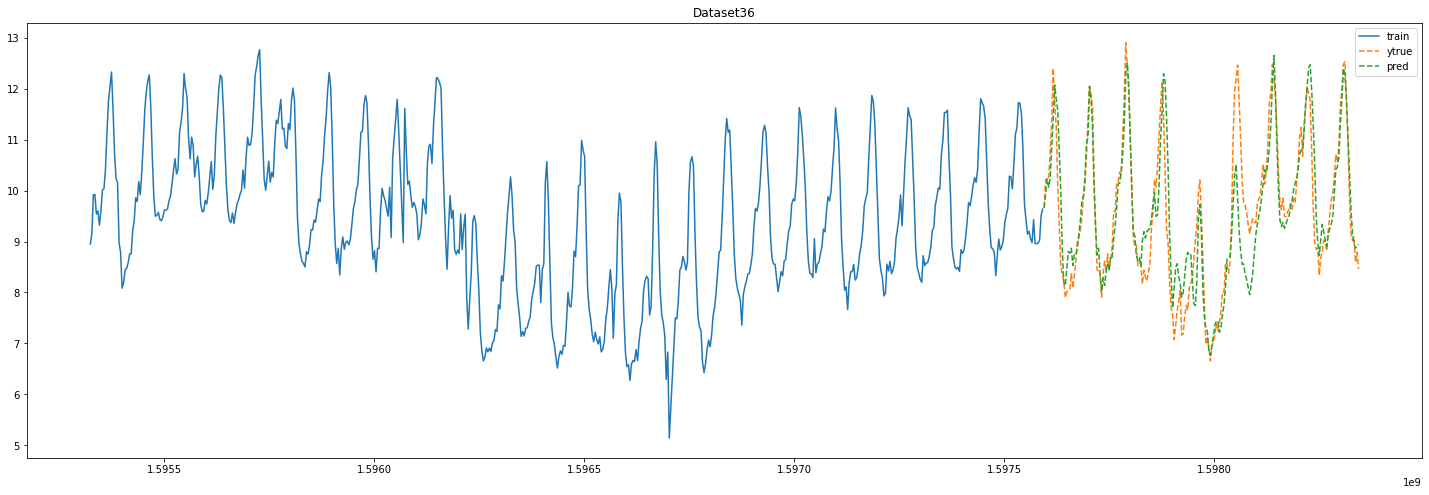

{'MAE': 0.40026504, 'MSE': 0.3280333, 'RMSE': 0.5727419, 'MAPE': 4.2222824}


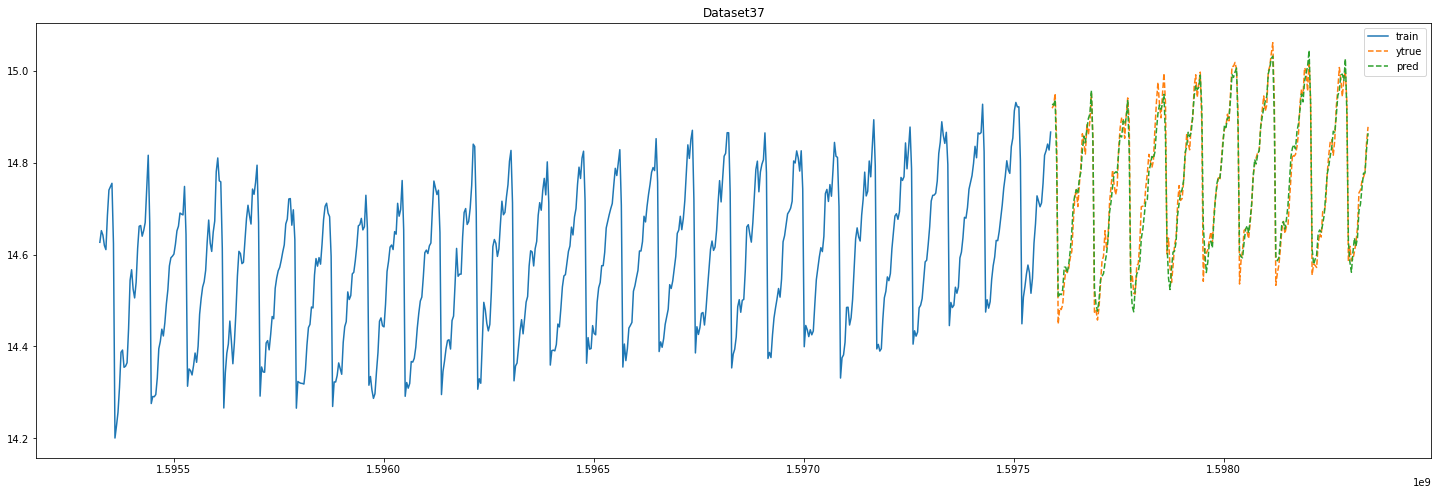

{'MAE': 0.022329807, 'MSE': 0.00081940414, 'RMSE': 0.028625235, 'MAPE': 0.15136987}


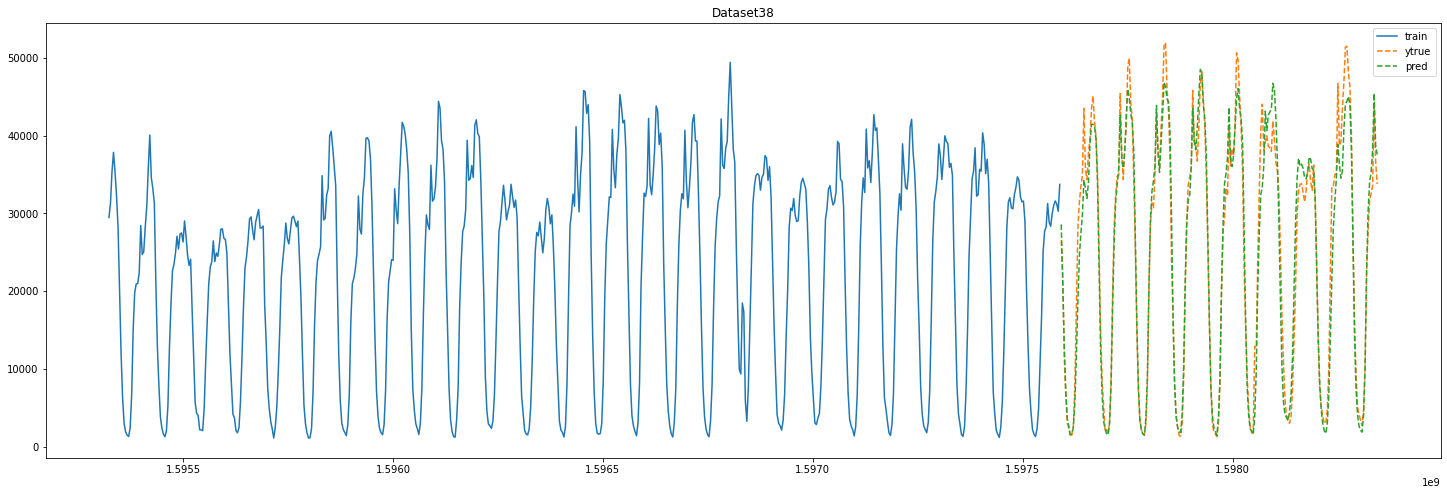

{'MAE': 2066.2478, 'MSE': 8635366.0, 'RMSE': 2938.5994, 'MAPE': 11.492488}


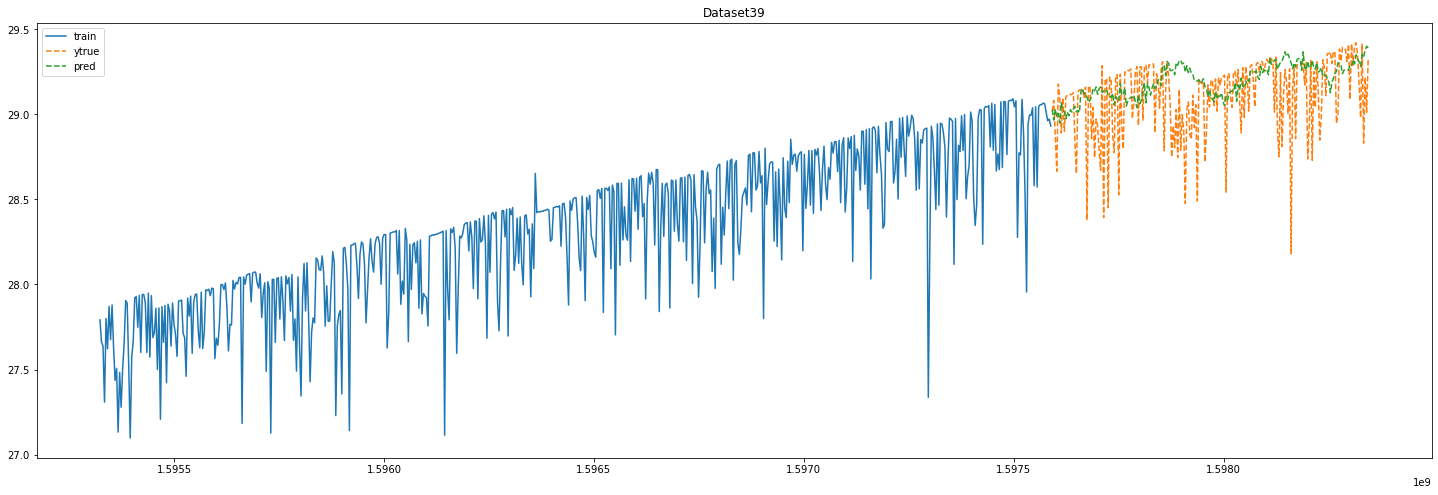

{'MAE': 0.17638189, 'MSE': 0.06240991, 'RMSE': 0.24981976, 'MAPE': 0.61013836}


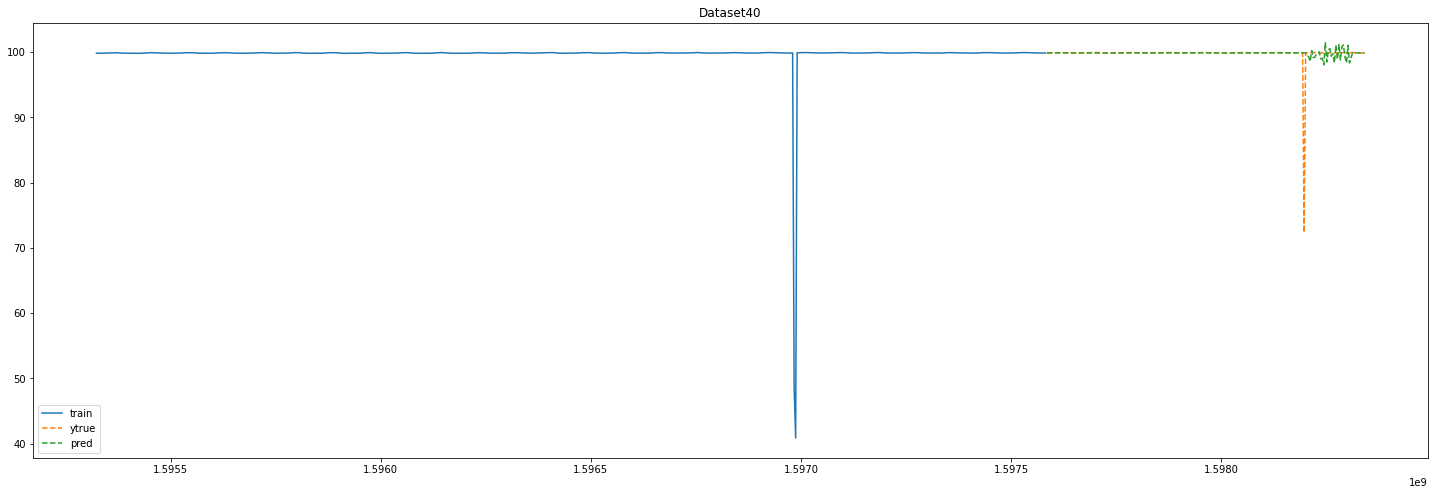

{'MAE': 0.3249594, 'MSE': 4.7019534, 'RMSE': 2.1683989, 'MAPE': 0.3753146}


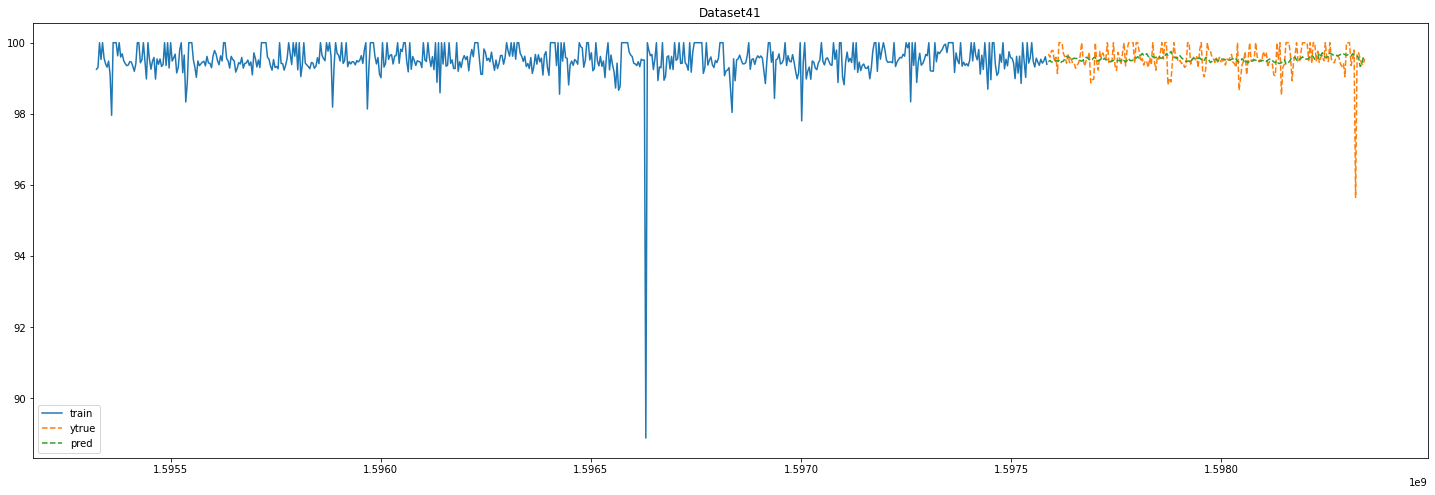

{'MAE': 0.25223693, 'MSE': 0.16736078, 'RMSE': 0.40909752, 'MAPE': 0.25405875}


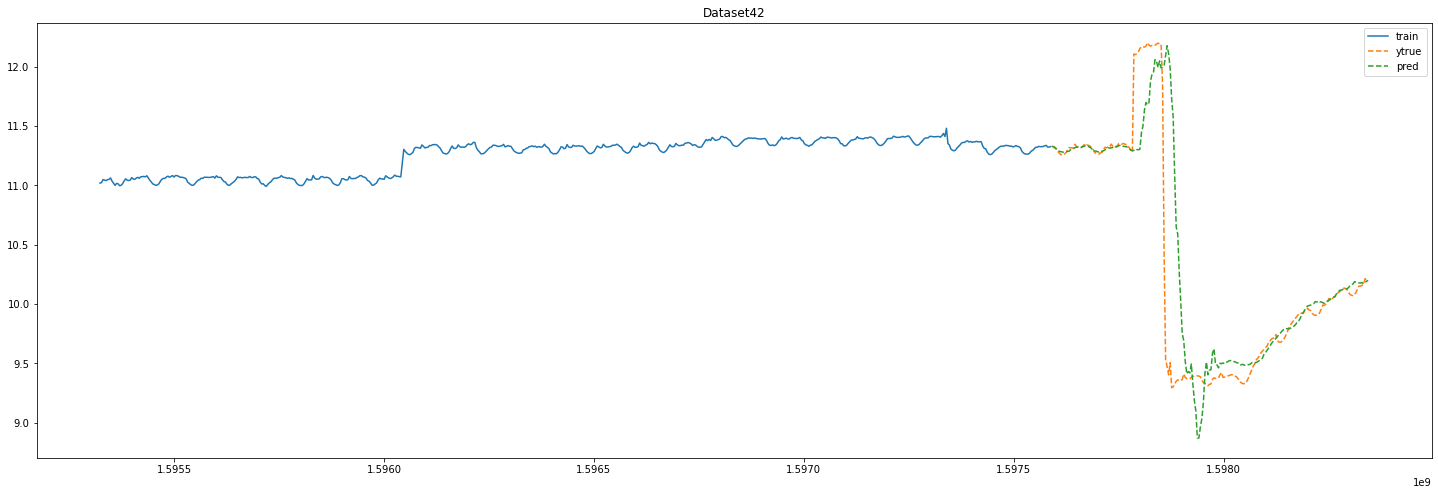

{'MAE': 0.30545744, 'MSE': 0.50935763, 'RMSE': 0.7136929, 'MAPE': 3.134291}


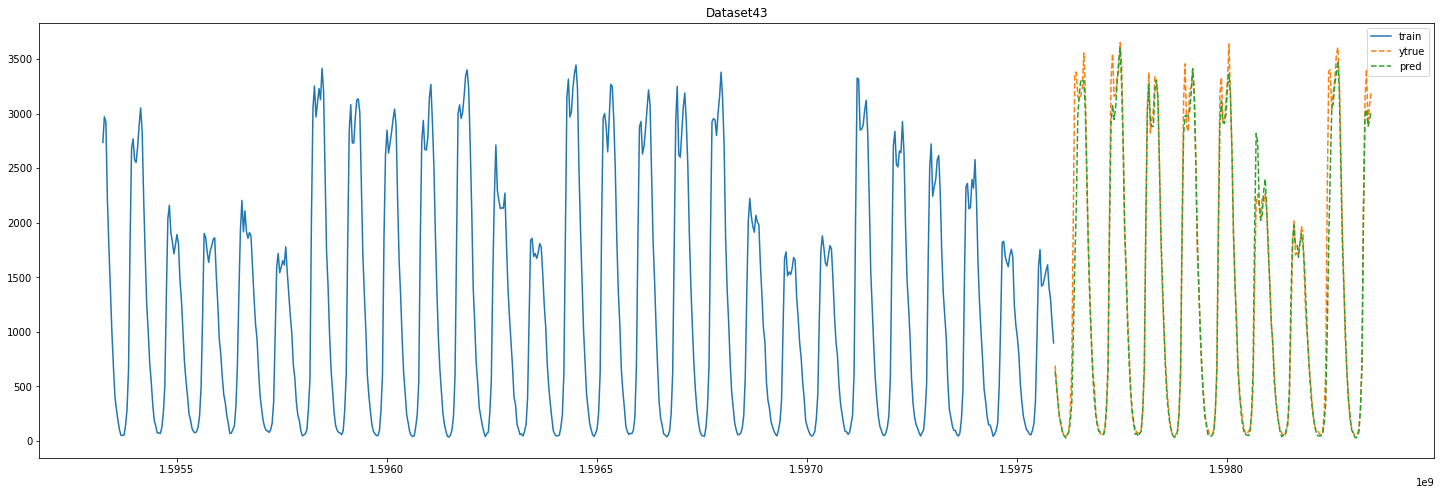

{'MAE': 97.92102, 'MSE': 45720.438, 'RMSE': 213.82338, 'MAPE': 11.313593}


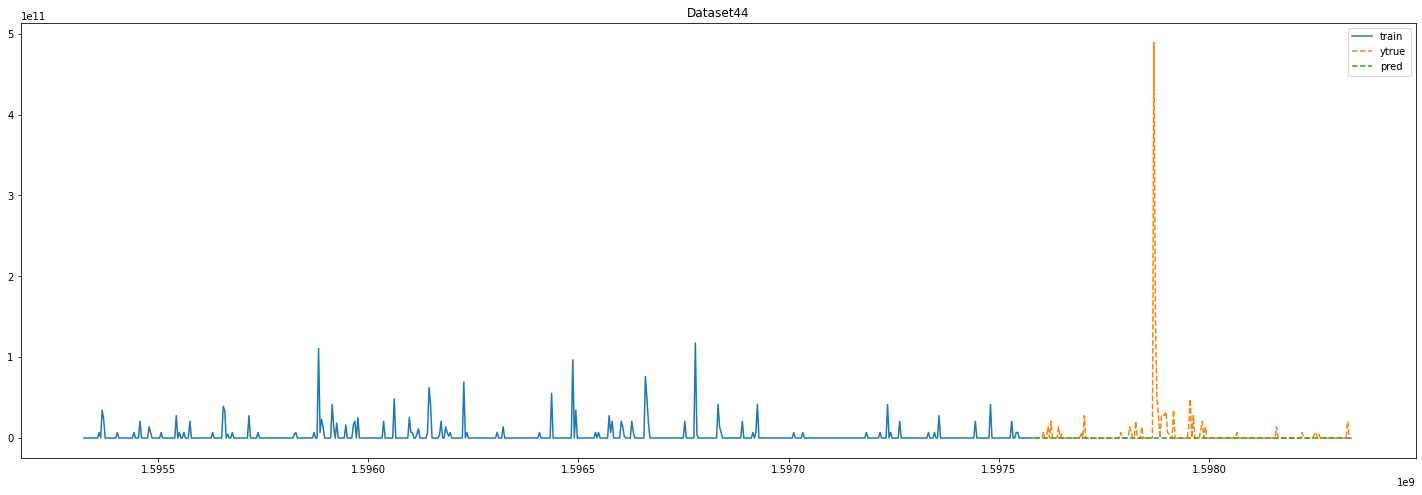

{'MAE': 5896613000.0, 'MSE': 1.3211478e+21, 'RMSE': 36347597000.0, 'MAPE': 2716.797}


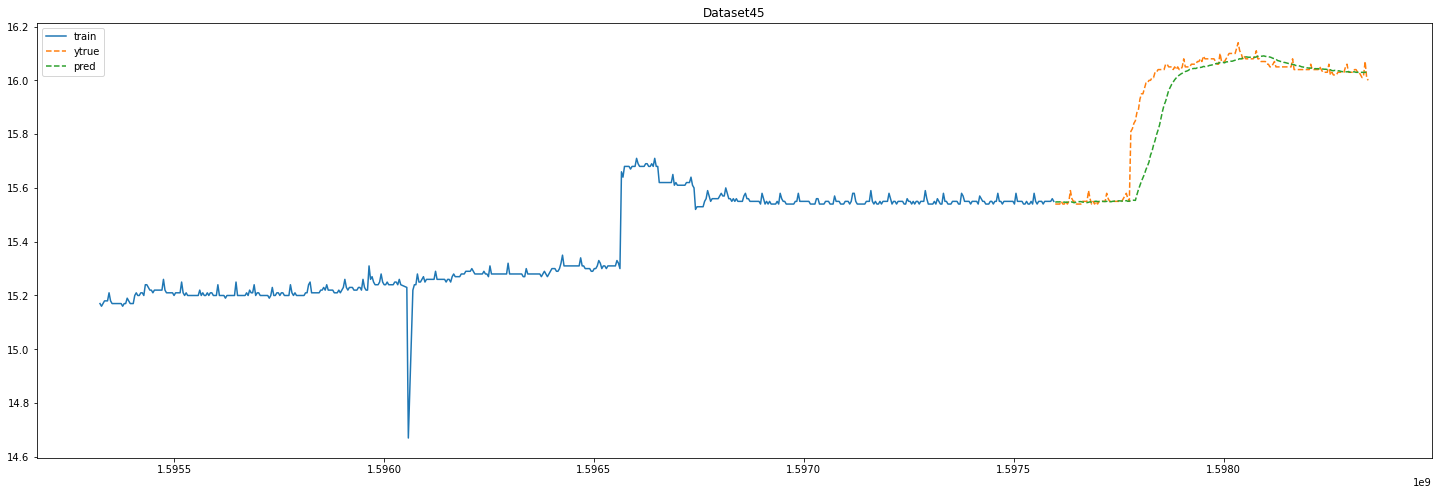

{'MAE': 0.03819916, 'MSE': 0.006696764, 'RMSE': 0.08183376, 'MAPE': 0.239304}


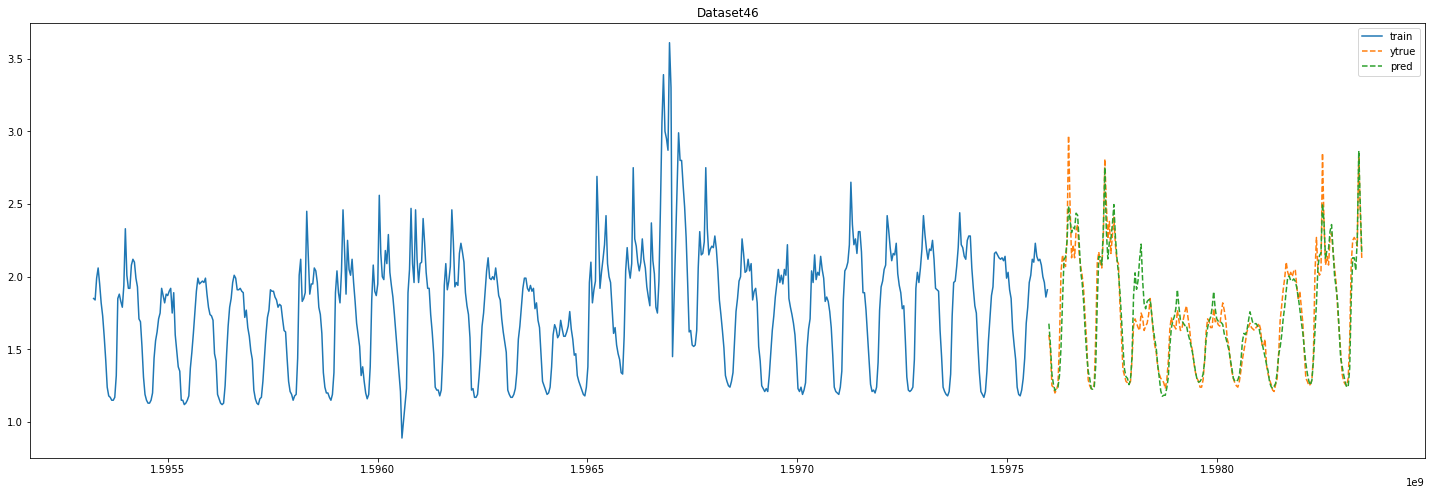

{'MAE': 0.07721924, 'MSE': 0.013264669, 'RMSE': 0.11517234, 'MAPE': 4.31004}


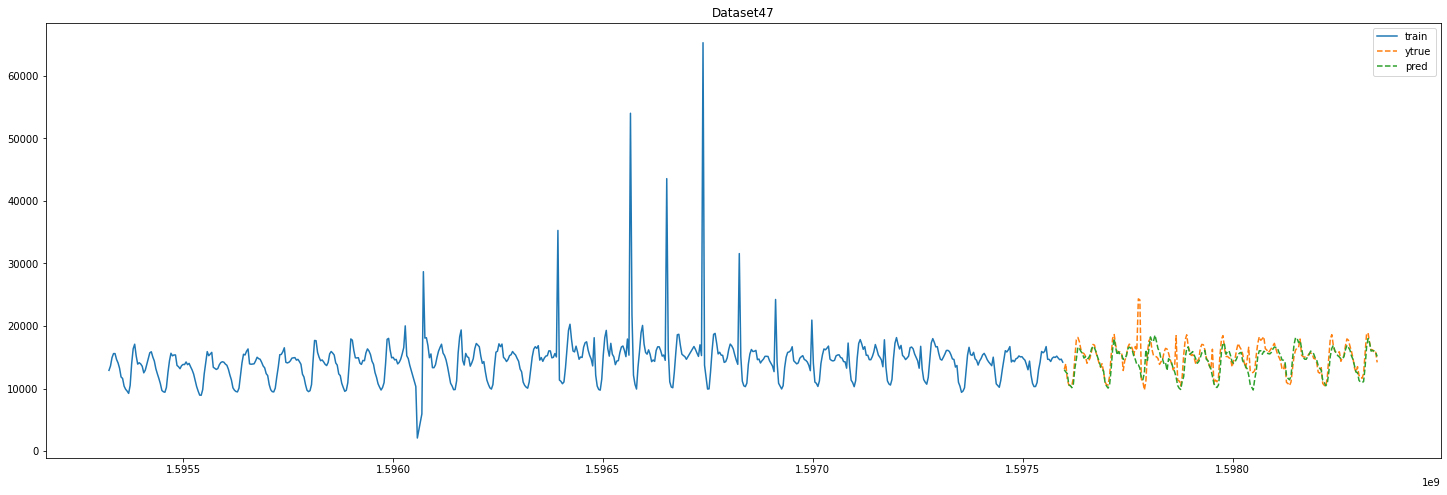

{'MAE': 984.52893, 'MSE': 2746114.8, 'RMSE': 1657.1405, 'MAPE': 6.393791}


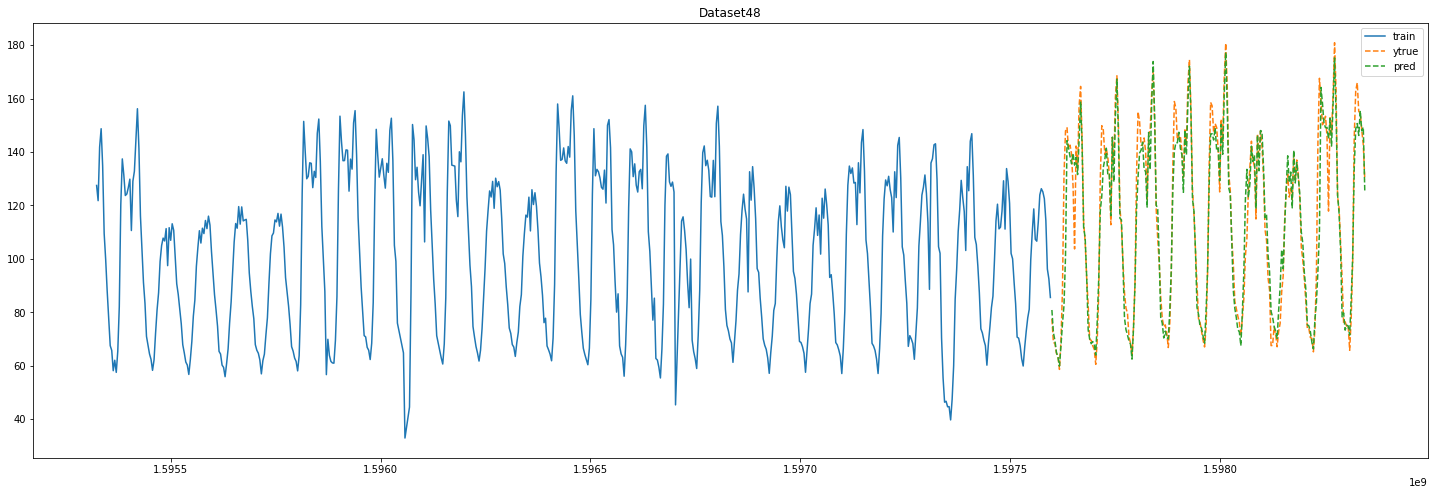

{'MAE': 5.4628134, 'MSE': 78.56601, 'RMSE': 8.863747, 'MAPE': 4.868144}


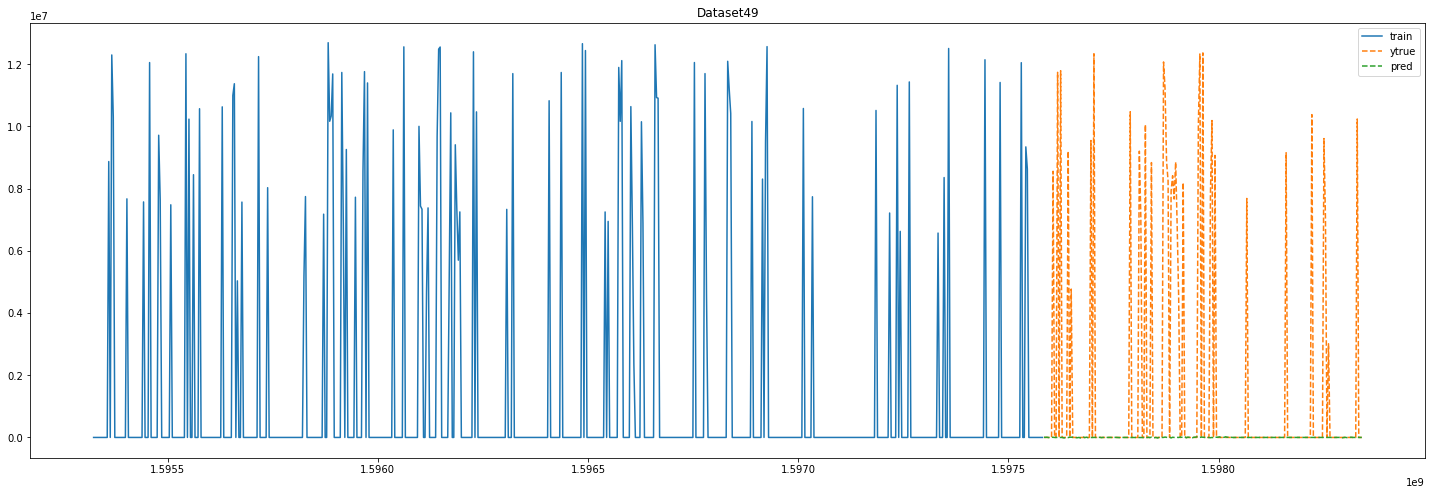

{'MAE': 1551796.6, 'MSE': 14796464000000.0, 'RMSE': 3846617.2, 'MAPE': 11822.602}


In [17]:
for i,(para,files) in enumerate(zip(model_para_arr,ipfiles)):
  #getting the data file wise
  pddata = pd.read_csv(f'dataset50/{files}',index_col = 0)

  # using the data to retrain the model with best hyperparametes
  # using the oobdata to generate the results/predictions
  data,oobdata = oobsplit(pddata)
  train_dataset,test_dataset = prep_data(data,para['WINDOW_SIZE'],para['HORIZON'],128)
  oob_dataset_tensor = prep_data(oobdata,para['WINDOW_SIZE'],para['HORIZON'],128,oob=True)


  model = ModelTrain(train_dataset,test_dataset,**para)
  preds = make_preds(model, oob_dataset_tensor)#getting the predictions from oobdata

  #getting the windowed form of oobdata to calculate the evaluation metrices
  _,ytrue = WindowHorizon(make_window(oobdata),para['WINDOW_SIZE'],para['HORIZON'],oob=True) 

  
  if para['HORIZON']>1:
    # taking the first value from the array of prediction series
    pred = [value[0].numpy() for value in preds ]
  else:
    pred = preds
    
  score = evaluate_preds(ytrue,preds)
  plot_preds(pddata,i,ytrue,pred,score)